# ABSTRACT
  
This tutorial provides guidance on creating a machine learning model to identify crop types from satellite imagery and other earth observation data. For users with a sample of known crop locations, the tutorial demonstrates and describes the steps required to train a model on the known samples and predict crop locations for a wider area of interest.   
  
# CONTENTS
  
**Overview**  
  
* Crop Type Mapping Overview
* Geospatial Data and Tools
  * Data Structures
  * GIS in Python and Google Earth Engine for Earth Observation Data  
  
**Introduction to Data**  
  
* Survey Data
* Earth Observation Data Sets
  * Sentinel-2 (S2) Optical Satellite Imagery
  * Additional EO Data
    * Shuttle Radar Topography Mission (SRTM) Data
    * aWhere Climate Data
  
**Developing Crop Type Mapping Model**  
  
* Data Ingestion and Pre-Processing  
  * Survey Data
    * Visualizing Geographic Areas
    * Calculating Plot Areas  
  * EO Data
    * Sentinel-2 Level-2A Imagery
      * Index Time Series and Crop Phenology
      * Obtain Harmonic Coefficients
    * Shuttle Radar Topography Mission Data
    * aWhere Climate Data
      * Obtaining Observed Weather
* Generate Composites
  * Excluding Plot Observations
  * Sample Size
  * Feature Pre-Selection
* Train and Tune Model
  * Train and Test Subsets
  * Hyperparameter Tuning
  
**Generate Predicted Cultivation Maps**
  
* Apply Trained and Tuned Model to Full Area of Interest
* Generate Predicted Cultivation Maps
  
  
# OVERVIEW

## Crop Type Mapping Overview

Smallholder farms are increasingly in the spotlight of development goals at a national and international level. As changing climates and growing populations increase food scarcity, creating sustainable food systems has become a major focus.[<sup>1</sup>](#fn1) However, monitoring the progress of these farms has been a challenge, as researchers and policy makers have relied on surveys or manual labeling of imagery to identify the type and scope of farming operations.[<sup>2</sup>](#fn2) There is an acute need for new approaches to monitoring smallholder agriculture systems, particularly in developing countries; these are the primary focus of development goals, yet they often lack the resources to facilitate consistent, widespread monitoring.  
  
The 50x2030 Initiative to Close the Agricultural Data Gap, a new initiative being implemented as a partnership between the World Bank, Food and Agriculture Organization of the United Nations (FAO), and the International Fund for Agriculture Development (IFAD), is one program working to address food insecurity using data-driven techniques. 50x2030 was developed to improve the use of data for agriculture in 50 low and middle-income countries, aiming to reduce the productivity losses these countries suffer from agricultural investments made without evidence for their effectiveness.[<sup>3</sup>](#fn3)  
  
In support of 50x2030, developers at Atlas AI, a firm applying AI techniques to economic and agricultural development, partnered with the World Bank to scale-up the integration of satellite and survey data for agricultural use cases. Particularly, they are working to increasing the knowledge base around using these techniques for agricultural monitoring as well as provide public datasets and maps identifying crop types. Their first working paper, _Understanding the Requirements for Surveys to Support Satellite-Based Crop Type Mapping : Evidence from Sub-Saharan Africa_[<sup>4</sup>](#fn4) (2021), provides recommendations for household survey collections to improve machine learning models which identify crop types from satellite imagery. Specifically, they provide guidance for surveys which collect geocoded, agricultural information including crop types under cultivation for each household. Using maize plots in Malawi and Ethiopia as the basis of their analysis, they test a single, optimized model with varying data inputs to identify which collection of inputs to the model provide the best results. They use household-level survey data and corresponding geospatial plot information as inputs to the models, and they find that with the optimal combination of inputs they are able to identify pixels with maize cultivation with up to 75 % accuracy.  
  
The Atlas AI team determined that the best crop type classification performance is achieved by collecting a complete plot boundary and then using features aggregated over the entire plot (i.e. plot mean) as inputs to the machine learning pipeline. Performance for their models was highest when using at least 3,000 - 4,000 sample plots. They found the best results when they did not remove any plots from their training data based on a size threshold, and finally they determined that optical satellite imagery can optimize prediction quality without the need for additional satellite products such as Synthetic Aperture Radar (SAR). In this learning module, we will reproduce the steps necessary to create this optimized machine learning model, allowing a user to replicate the process themselves for any location or product of interest given the appropriate survey responses.  


<span id="fn1">1. “Food Sustainability and the Role of Smallholder Farmers.” 2017. BCFN Foundation: Food and Nutrition Sustainability Index. April 24, 2017. https://foodsustainability.eiu.com/food-sustainability-and-the-role-of-smallholder-farmers/.</span>   
<span id="fn2">2. Azzari, George, Shruti Jain, Graham Jeffries, Talip Kilic, and Siobhan Murray. 2021. Understanding the Requirements for Surveys to Support Satellite-Based Crop Type Mapping: Evidence from Sub-Saharan Africa. Policy Research Working Papers. The World Bank. https://doi.org/10.1596/1813-9450-9609.</span>  
<span id="fn3">3. “About | 50 by 2030.” 2019. October 11, 2019. https://www.50x2030.org/about.</span>  
<span id="fn4">4. Azzari, G., Jain, S., Jeffries, G., Kilic, T., and Murray, S. (2021). "Understanding the Requirements for Surveys to Support Satellite-Based Crop Type Mapping: Evidence from Sub-Saharan Africa." World Bank Policy Research Working Paper No. 9609, LSMS Washington, DC: World Bank.</span>  

## Geospatial Data and Tools
  
### Data Structures
In geospatial data analysis, data can be classified into two categories: raster and vector data. A graphic comparison between raster and vector data can be found in the World Bank [Nighttime Lights Tutorial module 2, section 1](https://worldbank.github.io/OpenNightLights/tutorials/mod2_1_data_overview.html).

* **Raster data**: Data stored in a raster format is arranged in a regular grid of cells, without storing the coordinates of each point (namely, a cell, or a pixel). The coordinates of the corner points and the spacing of the grid can be used to calculate (rather than to store) the coordinates of each location in the grid. Any given pixel in the grid stores one or more values (in one or more bands).
* **Vector data**: Data in a vector format is stored such that the X and Y coordinates are stored for each point. Data can be represented, for example, as points, lines and polygons. A point has only one coordinate (X and Y), a line has two or more coordinates, and a polygon is essentially a line that closes on itself to enclose a region. Polygons are usually used to represent the area and perimeter of continuous geographic features. Vector data stores features in their original resolution, without aggregation.

In this tutorial, we will use vector and raster data. Geospatial data in vector format are often stored in a **shapefile**, a popular format for storing vector data developed by ESRI. The shapefile format is actually composed of multiple individual files which make up the entire data. At a minimum, there will be 3 file types included with this geographic data (.shp, .shx, .dbf), but there are often other files included which store additional information. In order to be read and used as a whole, all file types must have the same name and be in the same folder. Because the structure of points, lines, and polygons are different, each shapefile can only contain one vector type (all points, all lines, or all polygons). You will not find a mixture of point, line, and polygon objects in a single shapefile, so in order to work with these different types in the same analysis, multiple shapefiles will need to be used and layered. For more details on shapefiles and file types, see [this documentation](https://desktop.arcgis.com/en/arcmap/latest/manage-data/shapefiles/shapefile-file-extensions.htm).  
    
Raster data, on the other hand, is stored in Tagged Image File Format (TIFF or TIF). A GeoTIFF is a TIFF file that follows a specific standard for structuring meta-data. The meta-data stored in a TIFF is called a tif tag and GeoTIFFs often contain tags including spatial extent, coordinate reference system, resolution, and number of layers.   
  
More information and examples can be found in sections 2 & 3 of the [Earth Analytics Python Course](https://www.earthdatascience.org/courses/earth-analytics-python/spatial-data-vector-shapefiles/).  
  
### GIS in Python and Google Earth Engine for Earth Observation Data
  
We'll be sourcing the EO data used in this process from [Google Earth Engine](https://earthengine.google.com/). For necessary Python setup and an introduction to our use of the GEE Python API, see the [World Bank Nighttime Light Tutorial](https://worldbank.github.io/OpenNightLights/tutorials/mod2_2_getting_started_with_Python.html), module 2 sections 2-5. In particular, before proceeding you will need to have `jupyter` and `geemap` installed on your machine, and you will need to apply for a Google Earth Engine account [here](https://signup.earthengine.google.com/). **It may take a day or longer** for your Google Earth Engine account to be granted access.  
  
Two of the primary packages we'll be using, `Pandas` and `GeoPandas`, must be installed according to their installation instructions: [Pandas Installation](https://pandas.pydata.org/pandas-docs/stable/getting_started/install.html) and [GeoPandas Installation](https://geopandas.org/getting_started/install.html). If you're on Windows, `GeoPandas` installation can occasionally be temperamental - using an environment, as in the World Bank Nighttime Lights Tutorial, can often circumvent any issues, but if you're still having problems, there are a number of guides online, such as this [Practial Data Science guide](https://www.practicaldatascience.org/html/gis_setup_geopandas.html) or this [Medium post](https://nayanemaia.medium.com/installing-geopandas-on-windows-aadd762c557c) by Nayane Maia, which provide installation help that may allow you to be more successful. Using [Windows Subsystem for Linux (WSL)](https://docs.microsoft.com/en-us/windows/python/web-frameworks) can also make use of tricky packages like GeoPandas easier.  

# INTRODUCTION TO DATA
   
## Survey Data
  
While the survey data used in identifying crop types will differ by location and time period of interest for your use case, for the purposes of this module we will leverage the survey data used by Azzari et al. in their working paper: the Integrated Household Panel Survey (IHPS) 2019 and the Fifth Integrated Household Survey (IHS5) 2019/2020, both of which were implemented by the Malawi National Statistical Office. While these were designed to measure consumption and poverty, they also provide valuable information on agricultural activities. Both utilized identical agricultural questionnaires which not only identified crop type and distribution within and across plots, but also captured the GPS coordinates for the plot perimeters and corners wherever possible. These provide household-level responses from Malawi between 2018-2020.  
  
The survey data and associated documentation for both the [Integrated Household Panel Survey 2019](https://microdata.worldbank.org/index.php/catalog/3819) and the [Fifth Integrated Household Survey 2019/2020](https://microdata.worldbank.org/index.php/catalog/3818) can be found in the World Bank's Microdata Library. Both of these sources are Public Use Files, meaning they are available for users who agree to only utilize their contents for statistical and scientific research at an aggregated level and as part of a larger product. To use this data, you'll need to register and agree to the full terms of use, which you can find [here](https://microdata.worldbank.org/index.php/terms-of-use). Note that the GPS coordinates are **not** available as part of the World Bank's Microdata Library due to privacy concerns. For any survey data you'll use, you'll need to ensure you have secure access to GPS locations for the plots. For this demonstration, since the GPS locations are not available, we'll be working with sample plots. 

## Earth Observation (EO) Data Sets
    
### Sentinel-2 (S2) Optical Imagery

The method refined by Atlas AI and the World Bank to identify crop type from satellite imagery utilizes optical imagery sourced from Sentinel-2 (S2) satellites. The S2 satellites are part of the Copernicus initiative, which was developed by the European Space Agency and the European Comission to provide Atmospheric, Oceanic, and Land monitoring of Earth for a multitude of applications.[<sup>5</sup>](#fn5) The Sentinel-2 mission consists of two identical satellites: Sentinel-2A, launched June 23, 2015, and Sentinel-2B, launched March 7, 2017. The MultiSpectral Instrument (MSI) onboard each satellite passively collects sunlight reflected from earth within 13 spectral bands ranging from Visible and Near-Infrared (VNIR) to Shortwave Infrared (SWIR) wavelengths. These are used to enable vegetation, land cover, and environmental monitoring of all of Earth's land surfaces and coastal waters every five days.[<sup>6</sup>](#fn6)  
  
We will be using [S2 Level-2A imagery](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/product-types/level-2a) to make predictions of maize production. The Level-2A product provides 100x100 $km^2$ ortho-images, which means the images have been **orthorectified** to remove distortion caused by differing terrain and sensor angles when the images were collected. Orthorectification allows the images to be used to accurately measure and quantify land features and distances. For more information on orthorectification, see [this](https://www.usgs.gov/faqs/what-a-digital-orthophoto-quadrangle-doq-or-orthoimage?qt-news_science_products=0#qt-news_science_products) USGS brief explanation or [this](https://www.satimagingcorp.com/services/orthorectification/) more detailed description from the Satellite Imaging Corporation. The Sentinel-2 Level-2A Optical Imagery can be obtained from [Google Earth Engine](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR#description) with the identifier "COPERNICUS/S2_SR".  
  
The Level-2A product provides Bottom Of Atmosphere (BOA) reflectance, or Surface Reflectance (SR), images, which are derived from Sentinel-2 [Level-1C Top Of Atmosphere (TOA) reflectances](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/product-types/level-1c). TOA reflectance values represent all lights which are reflected back to the satellite from the earth or the atmosphere. For analyses like ours, which are interested in the land cover, the presence of atmospheric reflections can distort the interpretation of the image, as they are blended with the reflectances from earth. To remove this potential source of distortion, atmospheric corrections can be applied to reduce or remove the effect of reflectances from the atmosphere and only retain the light reflected from the ground. The Level-2A product is the result of processing the Level-1C product to remove atmospheric reflectance, and thus is the preferred source for our investigation of crop type. However, the Level-2A product is only available after 2018, so if you have need of Bottom Of Atmosphere imagery from an earlier time period, you'll need to perform this processing of the Level-1C imagery. The [Sentinel-2 Toolbox](https://sentinel.esa.int/web/sentinel/toolboxes/sentinel-2) provides a mechanism to perform this correction, or for a Python solution, [this Github repository](https://github.com/samsammurphy/gee-atmcorr-S2/blob/master/jupyer_notebooks/sentinel2_atmospheric_correction.ipynb) contains code for this task.  

Sentinel-2 imagery records values for multiple spectral bands, but in practice, rather than being used individually, these bands are often combined into **indices**. [Spectral indices](https://un-spider.org/index.php/links-and-resources/data-sources/daotm/daotm-vegetation) can combine multiple bands with complementary information into a single value which can provide more information on ground cover than the individual bands.  Our analysis will use the Red Edge 4 (RDED4) band along with the Green Chlorophyll Vegetation Index (GCVI), Normalized Burn Ratio 1 (NBR1), Normalized Difference Temperature Index (NDTI), Normalized Difference Vegetation Index (NDVI), and Smoothed Normalized Difference Vegetation Index (SNDVI), all of which are calculated from S2 bands. Azzari et al. provide the equations for these indices in section 2.2.2 of _Understanding the Requirements for Surveys to Support Satellite-Based Crop Type Mapping : Evidence from Sub-Saharan Africa_, and the code they provide will perform these calculations as well.     
     
        
<span id="fn5">5. “Missions - Sentinel Online - Sentinel Online.” n.d. Accessed July 5, 2021. https://sentinel.esa.int/web/sentinel/missions.</span>    
<span id="fn6">6. Earth Resources Observation And Science (EROS) Center. 2017. “Sentinel.” Tiff,jpg. U.S. Geological Survey. https://doi.org/10.5066/F76W992G.</span>  

  
### Additional Earth Observation Data Sources
  
While the core components of this model are the satellite imagery and the survey data, Azzari et al. also found it helpful to incorporate additional Earth Observation (EO) data sources into their predictive model. They selected features of the landscape and climate which are correlated with the selection of crop types for given plots of land.


#### Topography Features: Elevation, Slope, and Aspect
  
In order to assess cropland suitability, the team utilized elevation, slope, and aspect (the direction of the slope) as proxies. These selections were made under the assumption that erosion and soil degradation are exacerbated by high slope and elevation, thus making these areas less likely to be strong agricultural sites. Elevation, slope, and aspect can be obtained from the [Shuttle Radar Topography Mission (SRTM)](https://www2.jpl.nasa.gov/srtm/) datasource, which is available at a resolution of 30m. The Shuttle Radar Topography Mission, flown on the space shuttle Endeavour in February, 2000, was used by the National Aeronautics and Space Administration (NASA) and the National Geospatial-Intelligence Agency (NGA) to create near-global land elevation data. This was accomplished through the use of two antennas on the Endeavour, with the surface elevation calculated as the difference between these signals.  
  
Multiple versions of this SRTM elevation data have been created from the original data collection, with subsequent versions performing tasks such as identifying and correcting for water bodies and filling voids. These versions are made available in 1 and 3 arc-second resolutions, where 1 arc-second corresponds to roughly 30m and 3 arc-second corresponds to apprximately 90m. For this model, we'll leverage Version 3.0 (also known as SRTM Plus), which was developed by NASA's Jet Propulsion Laboratory (JPL) to fill the voids in the elevation data with non-commercial data sources ASTER GDEM2 (a joint project of NASA and components of the Japanese government), GMTED2010 (developed by NGA and the U.S. Geological Survey (USGS)), and NED (developed by USGS). For more information on the SRTM versions and methodology, see the [SRTM User Guide](https://lpdaac.usgs.gov/documents/179/SRTM_User_Guide_V3.pdf). 


#### Climate Features: Average Temperature, Growing Degree Days (GDD), and Total Precipitation

Climate considerations are also an important component of cropland suitability, so these were also incorporated into this crop classification model. The climate variables included are average temperature, total precipitation, and growing degree days (GDD), with a growing degree day defined as a day where the mean temperature is greater than a base value that must be exceeded for a crop to grow.[<sup>7</sup>](#fn7) For maize, which is the crop we're using in this example, the base value defining a GDD is $10^o$ C.  
  
This weather data was obtained from the [aWhere Daily Observed Weather API](https://docs.awhere.com/knowledge-base-docs/daily-observed-weather/). aWhere provides hyperlocal, continuously updating weather information sourced from ground stations, Doppler radar, and satellite data. The Daily Observed Weather API provides temperatures and precipitation by location and day, and these values can be used to create the average temperature, GDD, and total precipitation metrics. 
  
<span id="fn7">7. Azzari, G., Jain, S., Jeffries, G., Kilic, T., and Murray, S. (2021). "Understanding the Requirements for Surveys to Support Satellite-Based Crop Type Mapping: Evidence from Sub-Saharan Africa." World Bank Policy Research Working Paper No. 9609, LSMS Washington, DC: World Bank. Pg. 14</span> 

# DEVELOPING CROP TYPE MAPPING MODEL
  
To classify satellite imagery, Azzari et al. utilize a **random forest** classification model. A random forest model consists of an **ensemble** of decision trees (ie, a set of multiple, individual decision trees), where each decision tree utilizes a series of **features** to determine the optimal classification for given observations. For an approachable overview of Random Forest Models, see this [Towards Data Science](https://towardsdatascience.com/understanding-random-forest-58381e0602d2) post by Tony Yiu, or for a more thorough overview see Chapter 8 of An Introduction to Statistical Learning by Gareth James, Daniela Witten, Trevor Hastie, and Rob Tibshirani, which can be downloaded for free [here](https://www.statlearning.com/). Further information on Random Forest models can also be found in The Elements of Statistical Learning: Data Mining, Inference, and Prediction, by Trevor Hastie, Rob Tibshirani, and Jerome Friedman, which can be downloaded free [here](https://web.stanford.edu/~hastie/ElemStatLearn/), and an introduction to Random Forests including Python example code can be found in Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow by Aurelien Geron.  
  
In order for our random forest model to successfully identify crop types, we need to provide it information (**features**) about each plot we hope to identify. We will need to provide these features for both the data set we use for training and for any additional plots we hope to classify using our trained model. The data sources we mentioned above - Sentinel-2 Imagery, Survey Data, and the additional Earth Observation data - will provide the features for our model.  
  
## Data Ingestion and Preprocessing
    
### Survey Data
  
As mentioned above, the survey data we'll be using is from Malawi and can be obtained (without the geocoded locations) through the World Bank's Microdata Library. For different locations or time periods, you'll need to obtain the appropriate associated survey results to use in the model. This example will thus move relatively quickly through the specifics of these Malawi surveys and instead focus on the fields which should be present in your final output. While the format and contents of each survey will vary, to be used in this model a survey must contain information including:
  
- Georeferenced plot locations, providing the plot boundary or all corner points
- Crop type for each plot - including all crops for intercropped plots
  
Azzari et al. also removed all plots with duplicated location information and without a high degree of confidence in the location data quality, which is recommended for the best model performance.   
  
We'll need to be able to identify each distinct plot as we collect the SRTM and Sentinel-2 data - we'll use the plot geographies to collect the associated SRTM and S2 information for each plot, but we should also create a unique identifier for each plot geography that we can use to link the plots together. While this will be different depending on the survey data you use, in our example, we could distinctly identify each plot by the 'y4_hhid', 'gardenid', 'plotid' combination (identified as unique by the survey documentation), either by keeping these as 3 separate columns, by combining them into a single identifier column, or by `hashing` these values to create a distinct numeric identifier. Hashing creates a unique number for a given line of text. Pandas can handle a join by string fields relatively well, but performance will be better when joining on numeric fields, so depending on the size of your sample, you may want to use hashing to create a numeric identifier for joins.  
  
We're unable to share survey data with full geographic identifiers, so for the survey data we'll provide a set of sample values to demonstrate what should be available in any survey data used for this model. These are based on the Malawi Integrated Household Panel Survey (IHPS3) 2019 and the Fifth Integrated Household Survey (IHS5) 2019/20, which were used by Azzari et al. In this case, hh_id (household id), garden_id, and plot_id are used to uniquely identify each plot, while the crop_codes identify which crops are planted in a given plot (ie, if only crop_code_a is provided, the plot is monocropped, while if multiple crop_codes are provided, the plot is intercropped). The plot_perimeter should be a geographic polygon of the plot boundaries. 

| unique_id  | hh_id | garden_id | plot_id | crop_code_a  | crop_code_b | crop_code_c | crop_code_d  | crop_code_e | plot_area | plot_perimeter |
| ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- |
| 0002-001-RG04-R01  | 0002-001  | RG04  | R01  | 1 | 34 | 12 |   |   | 1.51  | geom_poly  |
| 0049-005-RG02-R01 | 0049-005  | RG02 | R01   | 12 | 38  |  |  |  | 1.64 | geom_poly |
| 0087-003-RG03-R02 | 0087-003 | RG03 | R02   | 1 | 28 | 38 | 42 |  | 13.3 | geom_poly |


To create our tables, we can start with using [Pandas](https://pandas.pydata.org/), a popular and versitile tool for data analysis in Python. We can then create sample points and perimeter geometries to demonstrate the full range of use for the plots. We'll select two areas randomly within Malawi and select corner points to bound our sample plots. To create these points and geometries, we can use [GeoPandas](https://geopandas.org/index.html). `Geopandas` is a popular Python package for working with geographic data, and it will easily allow us to create geographic points and polygons from latitude and longitudes.  
  
To start, we will create our plot polygons from sample corner points randomly selected from Google Maps. We'll use `shapely.geometry.Polygon()` to create these shapes. We'll also define the Coordinate Reference System (CRS) we want `GeoPandas` to use when creating these points. One of the most common Coordinate Reference Systems is World Geodetic System 1984 (WGS84), which has the code EPSG:4326. This system defines locations on a three-dimensional surface using degrees, which is what we know as latitude and longitude and is used by GPS systems. For more information on Coordinate Reference Systems in Python, see this [Towards Data Science](https://towardsdatascience.com/how-to-handle-map-projections-properly-in-python-bcbff78895c4) tutorial by Abdishakur.  
  
Note: 'plot_c' has been created unusually large to ease visualization and analysis for the purpose of this tutorial.  

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon

plot_a = gpd.GeoDataFrame(pd.DataFrame({'plot':'plot_a'}, index=[0]), geometry = [Polygon([(34.557480,-14.305434),(34.556651,-14.305580),(34.556233,-14.305096),(34.557424,-14.304969)])], crs=4326)
plot_b = gpd.GeoDataFrame(pd.DataFrame({'plot':'plot_b'}, index=[0]), geometry = [Polygon([(33.932340,-11.566691),(33.931471,-11.567127),(33.931160,-11.566817),(33.931981,-11.566139)])], crs=4326)
plot_c = gpd.GeoDataFrame(pd.DataFrame({'plot':'plot_c'}, index=[0]), geometry = [Polygon([(33.340902,-13.601511),(33.339132,-13.602178),(33.338096,-13.600041, ),(33.340001,-13.599425)])], crs=4326)

#### Visualizing Geographic Areas  

With these polygons defined as plot_a, b, and c, we can visualize the plots using Google Earth Engine's mapping capabilities. If you're using Google Colab or other forms of Jupyter notebooks such as VSCode's integrated notebooks, you'll need to use `geemap.eefolium.Map()`. Otherwise, you can use `geemap.Map()`.   
  
Our first step will be to Authenticate the connection to Google Earth Engine. The first time you run this code, you'll need to Authenticate using the authentication code you're provided when you are granted GEE access. For more detailed instruction, see this [Introduction to Google Earth Engine](https://worldbank.github.io/OpenNightLights/tutorials/mod2_4_introduction_to_GEE.html) in the World Bank's Nighttime Lights tutorial.  
  
Finally, we'll first convert our `GeoPandas` polygons to geographic types that `geemap` will recognize, which we can do easily using `geemap.geopandas_to_ee()`. (For more information on converting between `geemap` and `geopandas`, see this [documentation](https://geemap.org/notebooks/geopandas/).) Once we've converted our plots, we can add them to a basemap from `geemap` to visualize the areas we'll be analyzing. 

In [2]:
import geemap.eefolium, ee

try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

In [3]:
ee_plot_a = geemap.geopandas_to_ee(plot_a).geometry()
center_lat = -14.305434
center_lon = 34.557480

map_plot_a = geemap.eefolium.Map(center=[center_lat,center_lon],zoom=15)
map_plot_a.add_basemap('SATELLITE')
map_plot_a.addLayer(ee_plot_a,vis_params={'color':'a4c639'},opacity=0.8)
map_plot_a

In [4]:
ee_plot_b = geemap.geopandas_to_ee(plot_b).geometry()
center_lat = -11.566691
center_lon = 33.932340

map_plot_b = geemap.eefolium.Map(center=[center_lat,center_lon],zoom=15)
map_plot_b.add_basemap('SATELLITE')
map_plot_b.addLayer(ee_plot_b,vis_params={'color':'a4c639'},opacity=0.8)
map_plot_b

In [26]:
ee_plot_c = geemap.geopandas_to_ee(plot_c).geometry()
center_lat = -13.600627
center_lon = 33.339620

map_plot_c = geemap.eefolium.Map(center=[center_lat,center_lon],zoom=15)
map_plot_c.add_basemap('SATELLITE')
map_plot_c.addLayer(ee_plot_c,vis_params={'color':'a4c639'},opacity=0.8)
map_plot_c

#### Calculating Plot Area
  
In our final dataset, we'll use these polygons, as Azzari et al. found that using the full plot areas produced one of the best performing models. If polygons or corner points are unavailable, other geographic identifiers such as plot centroids (the single point in the center of a plot) can be included in place of the polygons. One final task we can perform is to calculate the area of each plot - this may be useful if the area was not already provided with your survey.  
  
While we created our polygons with points in latitude and longitude, if we want to calculate area in meters we can't use our original CRS, as it's measured in degrees. Instead, we need to choose a CRS which can correctly identify meters around our given area of interest, which is Malawi. This will require using a *projected coordinate system*, which is defined on a two-dimensional surface and will allow us to use our traditional distance measures. To search for the appropriate CRS for a location, you can use https://epsg.io/ - we find that [EPSG:20936](https://epsg.io/20936) will work for Malawi. We can project to this CRS easily with geopandas using `to_crs()`. For more information about projections, see this [ESRI](https://desktop.arcgis.com/en/arcmap/latest/map/projections/projection-basics-for-gis-professionals.htm) explainer.

In [6]:
# Combine sample plots into single geodataframe
plots_gdf = pd.concat([plot_a,plot_b,plot_c]).reset_index()

# Project to appropriate CRS
plots_gdf.to_crs('EPSG:20936',inplace=True)
plots_gdf.crs

<Projected CRS: EPSG:20936>
Name: Arc 1950 / UTM zone 36S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Malawi. Zambia and Zimbabwe - east of 30°E.
- bounds: (30.0, -22.42, 35.93, -8.19)
Coordinate Operation:
- name: UTM zone 36S
- method: Transverse Mercator
Datum: Arc 1950
- Ellipsoid: Clarke 1880 (Arc)
- Prime Meridian: Greenwich

We can use `.area()` to obtain the area of each geometry in the units of our projection. Because we've projected our geometries to a CRS with units in meters (under the 'Axis Info' of the `.crs()` information above), the area of our plots will initially be returned in square meters. In order to convert to acres, which is a more common measurement for agricultural plots, we can use a conversion factor provided by [esri](https://support.esri.com/en/technical-article/000007350) of $m^2$ * 0.0002471054 = acres.

In [7]:
plots_gdf['plot_area'] = plots_gdf.area * 0.0002471054
plots_gdf

,index,plot,geometry,plot_area
0,0,plot_a,"POLYGON ((667960.790 8418253.597, 667871.248 8...",1.508917
1,0,plot_b,"POLYGON ((601630.450 8721518.054, 601535.535 8...",1.641266
2,0,plot_c,"POLYGON ((536850.549 8496642.083, 536658.975 8...",13.306660


Now that we have our areas calculated, we can convert our plots back to the CRS of EPSG:4326.

In [8]:
plots_gdf = plots_gdf.to_crs(4326)
plots_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Our final dataset can then be a `GeoPandas` GeoDataFrame with the following structure:

In [9]:
# Create sample dataframe with values above
survey_df = pd.DataFrame({'unique_id':['0002-001-RG04-R01','0049-005-RG02-R01','0087-003-RG03-R02'],
    'hh_id':['0002-001','0049-005','0087-003'],'garden_id':['RG04','RG02','RG03'],'plot_id':['R01','R01','R02'],
    'crop_code_a':[1,12,1],'crop_code_b':[34,38,28],'crop_code_c':[12,None,38],
    'crop_code_d':[None,None,42],'crop_code_e':[None,None,None]})

# Combine sample plot geometries into single geodataframe; add to sample dataframe
survey_df['plot_area'] = plots_gdf['plot_area']
survey_df['geometry'] = plots_gdf['geometry']
survey_df['plot'] = plots_gdf['plot']
survey_gdf = gpd.GeoDataFrame(survey_df)
survey_gdf

,unique_id,hh_id,garden_id,plot_id,crop_code_a,crop_code_b,crop_code_c,crop_code_d,crop_code_e,plot_area,geometry,plot
0,0002-001-RG04-R01,0002-001,RG04,R01,1,34,12.0,NaN,None,1.508917,"POLYGON ((34.55748 -14.30543, 34.55665 -14.305...",plot_a
1,0049-005-RG02-R01,0049-005,RG02,R01,12,38,NaN,NaN,None,1.641266,"POLYGON ((33.93234 -11.56669, 33.93147 -11.567...",plot_b
2,0087-003-RG03-R02,0087-003,RG03,R02,1,28,38.0,42.0,None,13.306660,"POLYGON ((33.34090 -13.60151, 33.33913 -13.602...",plot_c


As a final step, since we're interested in identifying whether a plot contains maize, we can create a field "maize_pos" if any of the crop codes are maize. Depending on your crop of interest and the structure of your survey data, the code you'll need for this may vary, but for this example we'll be looking for the crop codes 1, 2, 3, and 4 as identifications of maize. 

In [10]:
# define codes which identify maize
maize_codes = [1,2,3,4]
# identify True/False whether crop code columns have maize codes; sum these True/False values to identify if any contained maize
survey_gdf['maize_pos'] = survey_gdf.loc[:,('crop_code_a','crop_code_b','crop_code_c','crop_code_d','crop_code_e')].isin(maize_codes).sum(axis=1)
survey_gdf

,unique_id,hh_id,garden_id,plot_id,crop_code_a,crop_code_b,crop_code_c,crop_code_d,crop_code_e,plot_area,geometry,plot,maize_pos
0,0002-001-RG04-R01,0002-001,RG04,R01,1,34,12.0,NaN,None,1.508917,"POLYGON ((34.55748 -14.30543, 34.55665 -14.305...",plot_a,1
1,0049-005-RG02-R01,0049-005,RG02,R01,12,38,NaN,NaN,None,1.641266,"POLYGON ((33.93234 -11.56669, 33.93147 -11.567...",plot_b,0
2,0087-003-RG03-R02,0087-003,RG03,R02,1,28,38.0,42.0,None,13.306660,"POLYGON ((33.34090 -13.60151, 33.33913 -13.602...",plot_c,1


This dataframe can be easily joined by plot id or plot name to the subsequent sources of data we'll need for our model.

### EO Data  
  
#### Sentinel-2 Level-2A Imagery
  
To obtain our Sentinel-2 Level-2A imagery for Malawi, we will use Google Earth Engine's API to obtain the [Sentinel-2 MSI: MultiSpectral Instrument, Level-2A](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR#bands) _ImageCollection_. The S2 imagery needs to be pre-processed to **mask** pixels with clouds, shadows, haze, and snow so these do not influence our predictions of crop type. **Masking** pixels in an image makes the pixels transparent, so they will not be used in any of the operations or analysis performed. Masks are Images themselves that act as a guide for which pixels should be kept and which pixels should be made transparent. These mask Images can then be applied to other Images which cover the same area. Once applied, any pixels which have mask values which below a threshold (eg, mask values of 0) are made transparent on the image being masked. For more information and an example of masking, see Google Earth Engine's [Masking tutorial](https://developers.google.com/earth-engine/tutorials/tutorial_api_05?hl=en). Fortunately, one of the bands in the Sentinel-2 ImageCollection we'll use from Google Earth Engine is a Cloud mask, which identifies the pixels which represent clouds (both Opaque and Cirrus clouds). This enables us to identify and mask (make transparent) the pixels which don't represent land.  
    
The Atlas AI team of Azzari et al. have provided code which obtains the S2 imagery and performs the cloud masking, as well as code which we can use to compute the Vegetation Indices which they ultimately use in the model.  
  
First, though, let's define the area for our entire country of interest. We'll use this area to mask and calculate indices for the whole of Malawi, and then we can obtain the values for each plot from this overall Malawi map. We'll obtain the area of Malawi from FAO's Global Administrative Unit Layers 2015 ([FAO GAUL 2015](https://data.apps.fao.org/map/catalog/srv/eng/catalog.search#/metadata/9c35ba10-5649-41c8-bdfc-eb78e9e65654)), which provides country and administrative area boundaries for most of the world and is also available through GEE. Level 0 of the FAO GAUL layers is the country level, so we'll use the [GEE FeatureCollection of Level 0 boundaries](https://developers.google.com/earth-engine/datasets/catalog/FAO_GAUL_2015_level0?hl=en).  

In [11]:
# Obtain level0 boundaries, filter for Malawi, convert to geometry
malawi_geom = ee.Feature(ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.eq('ADM0_NAME', 'Malawi')).geometry())

# Visualize the area of Malawi we created
center_lat = -13.305434
center_lon = 34.557480

map_malawi = geemap.eefolium.Map(center=[center_lat,center_lon],zoom=6)
map_malawi.add_basemap('SATELLITE')
map_malawi.addLayer(malawi_geom,vis_params={'color':'a4c639'},opacity=0.8)
map_malawi

With this area to use as our geometry, we can now begin to use Azzari et al.'s code to pull in the Sentinel-2 data, mask the clouds, and calculate the indices.   
  
To make their code available for access on your machine, one option is to use Git to **clone** the repository. Cloning creates a copy of a **repository** (a collection of folders and files related to a specific project) on your machine which can be easily updated with Git commands rather than requiring re-downloading every change to the code. Using this Git method will require first installing Git on your machine according to [this guide](https://github.com/git-guides/install-git).   
  
Once installed, you can clone the [EETC repository](https://github.com/shrutijain90/eetc) by clicking the green 'Code' dropdown and copying the 'HTTPS' url (this should begin with 'https://' and end with '.git').    
  
<img src="img/eetc-git-clone.PNG" width="700" align="center"/>  
  
Next, open either Git Bash (for Windows) or your Terminal (for MacOS) and navigate to the folder you'd like to keep this code stored in. For the code in this tutorial to work exactly, you should store this eetc repository in the same folder as this Jupyter notebook is saved in. To navigate to your folder of choice, use the 'cd' command followed by the folder path: for example, 'cd Documents/Crop-Type-Mapping/'. Once in this folder, type 'git clone https://github.com/shrutijain90/eetc.git', and the files will be downloaded onto your machine.  
  
<img src="img/git-clone-eetc-gitbash.PNG" width="700" align="center"/>  
   
While Github is commonly used and helpful to learn, if you are unfamiliar with Git, you can also download a zip file of the code directly by selecting 'Download ZIP' in the dropdown of the green 'Code' button.  
  
<img src="img/eetc-download.PNG" width="700" align="center"/>  
  
You'll want to unzip this file into the same folder as this Jupyter notebook is saved.   
  
Once you've downloaded the 'eetc' folder using either of these methods, we can import the code to use. Specifically, we want to use their code for processing S2 Level-2A imagery, which is in the file eetc/gee_tools/datasources/sentinel2_2a. 

In [12]:
from eetc import gee_tools
import gee_tools.datasources.sentinel2_2a as s2_2a

From this code file, we'll be using the class `Sentinel2SR`. By providing a geometry (our Malawi area), start and end dates for the imagery we want, and orders to calculate indices, this code will return an `ImageCollection` containing Sentinel-2 images with the Vegetation Indices calculated.   

I'll define the start end end date by the growing season. I'll use late November through mid-April, according to the [FAO](http://www.fao.org/giews/countrybrief/country.jsp?code=MWI), though due to the existence of S2 Level-2A data only from late 2018 onward, some of the November dates may be unavailable. For this demonstration, it is not a problem, but if your use case requires dates in 2018 or before, you'll need to use the [S2 Level-1C product](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/product-types/level-1c) and perform the atmospheric corrections described above in Section 2: Introduction to Data.

In [13]:
# Obtain ImageCollection for specified area and dates with vegetation indices (addVIs) and cloud masks defined (addCloudMasks)
s2coll_2a = s2_2a.Sentinel2SR(malawi_geom.geometry(), start_date = ee.Date('2018-11-20'), end_date = ee.Date('2019-04-20'), addVIs=True, addCloudMasks=False).get_img_coll()

We can obtain a list of all the bands in the resulting ImageCollection by using this for loop to print each band name in the first Image in the collection:

In [6]:
for band in s2coll_2a.first().getInfo()['bands']:
    print(band['id'])

AEROS
BLUE
GREEN
RED
RDED1
RDED2
RDED3
NIR
RDED4
VAPOR
SWIR1
SWIR2
AOT
WVP
SCL
TCI_R
TCI_G
TCI_B
MSK_CLDPRB
MSK_SNWPRB
QA10
QA20
QA60
NBR1
NBR2
STI
NDTI
CRC
REIP
GCVI
RDGCVI1
RDGCVI2
MTCI
MTCI2
WDRVI
GRWDRVI
RDWDRVI
RDNDVI1
RDNDVI2
NDVI
SNDVI


We can see that there are not only the original bands from the S2-2A imagery, but also newly calculated bands for the vegetation indices.   
  
Next, we'll need to mask the clouds, which we can also do using code from Azzari et al. They use this code for `maskClouds_sr()` in eetc/gee_tools/datasources/toa_sr.py, which is used to convert the Sentinel-2 Level-1C Top Of Atmosphere reflectance to Surface Reflectance (and can also be used if you need to convert Level-1C to 2A for earlier dates). We'll only need this masking component for our purposes, so copying and pasting the masking function below will serve our needs. 

In [14]:
# Use Azzari et al's function to mask clouds
def maskClouds_sr(img, bandnames):
    scl = img.select(['SCL'])
    clear = scl.updateMask(scl.eq(4) or (scl.eq(5)))
    img = img.updateMask(clear)
    return img.select(bandnames)

We'll now apply this function to every image in our S2 ImageCollection using the function [imageCollection.map()](https://developers.google.com/earth-engine/guides/ic_mapping), which cycles through every image in an ImageCollection, applies the provided function to the image, and returns each processed image as a new ImageCollection.

In [15]:
# Define the bandames in the S2-2A data which we want to keep
bandnames = ['AEROS','BLUE','GREEN','RED','RDED1','RDED2','RDED3','NIR','RDED4','VAPOR','SWIR1','SWIR2','NBR1','NDTI','GCVI','NDVI','SNDVI']
# Mask clouds using the function above
s2coll_2a = s2coll_2a.map(lambda img: maskClouds_sr(img, bandnames))

Now, we can look into the ImageCollection we've created to ensure we have what we need. 

In [16]:
for band in s2coll_2a.first().getInfo()['bands']:
    print(band['id'])

AEROS
BLUE
GREEN
RED
RDED1
RDED2
RDED3
NIR
RDED4
VAPOR
SWIR1
SWIR2
NBR1
NDTI
GCVI
NDVI
SNDVI


Our ImageCollection is now ready for use. Let's try mapping one of the indices we just created to visualize the work we've done, limiting the range by only visualizing the GCVI for a buffer zone around our center point for simplicity. Note that it can take a few seconds for the GCVI layer to appear on the map.

In [17]:
center_lat = -15.783006
center_lon = 35.437013

gcvi_samp = s2coll_2a.select('GCVI').filterBounds(ee.Geometry.Point([center_lon,center_lat]).buffer(2000))

map_point_g = geemap.eefolium.Map(center=[center_lat,center_lon],zoom=10)
map_point_g.add_basemap('SATELLITE')
# set color range to use for GCVI levels: black is lowest, beginning at 0, through green as the highest, ending at 5
gcvi_params = {'min': 0, 'max': 5, 'palette': ['black','red', 'orange', 'yellow', 'green']}

map_point_g.addLayer(gcvi_samp, gcvi_params)
map_point_g

While these indices were created for us in Azzari et al.'s code, let's quickly go over calculation with image bands in case you need different indices or calculations. Complex expressions can be performed using the `Image.expression()` function. To use this, you provide the equation and the bands to use the equation and apply this equation to every image using `.map()`. For example, to calculate SNDVI, we use the formula (NIR - RED) / (NIR + RED + 0.16), where NIR is the 'NIR' band from the S2-2A imagery and RED is the 'RED' band.

In [ ]:
sndvi = s2coll_2a.map(lambda img: img.expression(
    '(NIR - RED) / (NIR + RED + 0.16)', {
        'NIR': img.select('NIR'),
        'RED': img.select('RED')
    }).rename('SNDVI'))

##### Index Time Series and Crop Phenology

Since we've obtained S2 imagery for our entire growing season duration, we can also visualize our data over time to view how GCVI, or any other band of interest, changes. The change in index values over time can provide important information, including a crop's growth cycle and pattern, known as **crop phenology**. As a crop grows from seed to full plant, the values of the indices for that area will also change, allowing researchers to obtain detailed information about a crop's growth. We can obtain some sample values for the GCVI band as an example.  
  
The ImageCollection we obtain from S2 is comprised of multiple satellite Images taken at different times and areas, and each image contains multiple bands - including those used to calculate NDVI, GCVI, and the other vegetation indices. In order to view changes in any band over time for the same location, with location being at the pixel level, we need to extract the values for each band at that specific pixel from all timestamped Images. 
  
Sentinel-2 satellites each pass over the same area every 10 days, so with the two Sentinel-2 satellites in operation, each location is captured once every 5 days: this is the **temporal resolution** of the images.[<sup>8</sup>](#fn8) [<sup>9</sup>](#fn9) The actual surface area measured by each pixel in an image is the **spatial resolution**. Each band in an S2 image has either 10m, 20m, or 60m spatial resolution, meaning each pixel can either represent a 10m x 10m area, 20m x 20m, or 60m x 60m.[<sup>10</sup>](#fn10) To identify the pixel size of a given band, you can consult the 'Bands' list in the [Earth Engine Data Catalog page for the Sentinel-2 Level-2A product](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR#bands). 
  
It is clear from these spatial and temporal resolutions that we will have a large number of pixels over even relatively small areas such as our sample plots, and the size is compounded by the multiple copies of these pixel for each date we have an image. The size of the data we're working with makes extracting this information in Python very time-consuming.   
  
For small areas (less than 262,144 pixels), we can extract values using Python with `geemap.ee_to_numpy()`, which uses the Google Earth Engine function `ee.Image.sampleRectangle()` to obtain the values, then converts them to a `numpy` array which we can work with in Python. For an example which obtains values over an area for a single image, see the [Extract pixels as a Numpy array](https://geemap.org/notebooks/11_export_image/) Geemap sample notebook. If your use case calls for extracting such values, you could follow the same process for a very small area. If you needed values for a larger area, you'll need to move to using Google Earth Engine: [this stackoverflow post](https://gis.stackexchange.com/questions/350771/earth-engine-simplest-way-to-move-from-ee-image-to-array-for-use-in-sklearn) is a helpful starting point.   

Obtaining pixel values over an area won't be necessary for our use case of developing an ML model, but it can be helpful to visualize these changes in indices over time as an indicator of crop phenology. This is an **optional step**, but we'll quickly demonstrate selecting a single point location and obtaining the GCVI values for this point to plot over time.  
  
First, we'll define a point of interest whose GCVI values we'll consider over time, and we'll obtain the S2 ImageCollection for a wider timeframe to have a more complete picture of the change in GCVI.    
    
      
<span id="fn8">8. “Sentinel-2 - Satellite Description - Sentinel Online - Sentinel Online.” n.d. Accessed September 2, 2021. https://sentinel.esa.int/web/sentinel/missions/sentinel-2/satellite-description.</span>  
<span id="fn9">9. “User Guides - Sentinel-2 MSI - Resolutions - Sentinel Online - Sentinel Online.” n.d. Accessed September 2, 2021. https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/resolutions.</span>   
<span id="fn10">10. “Sentinel-2 - Missions - Resolution and Swath - Sentinel Handbook - Sentinel Online.” n.d. Accessed September 2, 2021. https://sentinel.esa.int/web/sentinel/missions/sentinel-2/instrument-payload/resolution-and-swath.</span>  

In [27]:
# obtain extended timeframe for S2 SA imagery, if desired
s2coll_2a_ext = s2_2a.Sentinel2SR(malawi_geom.geometry(), start_date = ee.Date('2018-11-20'), end_date = ee.Date('2019-09-01'), addVIs=True, addCloudMasks=False).get_img_coll()
# Define the bandames in the S2-2A data which we want to keep
bandnames = ['AEROS','BLUE','GREEN','RED','RDED1','RDED2','RDED3','NIR','RDED4','VAPOR','SWIR1','SWIR2','NBR1','NDTI','GCVI','NDVI','SNDVI']
# Mask clouds
s2coll_2a_ext = s2coll_2a_ext.map(lambda img: maskClouds_sr(img, bandnames))

In [19]:
# create point_f as earth engine point of interest for which to pull GCVI values
ee_point_g = ee.Geometry.Point(35.437013,-15.783006)

In [20]:
map_point_g = geemap.eefolium.Map(center=[-15.783006, 35.437013],zoom=14)

map_point_g.add_basemap('SATELLITE')
map_point_g.addLayer(ee_point_g, vis_params={'color':'a4c639'})
map_point_g

Now, we'll define some functions to perform multiple tasks for us:
* Extract only our band of interest from the S2 image collection, s2coll_2a
* Filter for only the Images which contain our sample point, ee_point_g
* Obtain a list of all the Image IDs to use to cycle through and extract values
* Obtain a list of all the Image timestamps to link with the values
* Collapse the ImageCollection into a single Image with each original Image as a band
* Cycle through these bands and, if not masked, extract the GCVI value from them
* Return all GCVI values with timestamps as a Pandas DataFrame  

This will take a while to run: for the sample point g and our time frame, there are 52 Images to work through. Most of these are covered by clouds and masked. You'll be able to see the process at work through the print statements. One way we could make the processing go faster is to sample only a select number of images. The function includes the option to sample every xth image, according to [this stackoverflow suggestion](https://stackoverflow.com/questions/1403674/pythonic-way-to-return-list-of-every-nth-item-in-a-larger-list), but in the interest of ensuring we capture every image not covered by clouds, we'll refrain from sampling for this example.

In [25]:
# create list of all image timestamps
def create_timestamp_list(imgcoll): 
    """
    Create list of timestamps for all Images in ImageCollection
    Inputs:
        imgcoll (ImageCollection): ImageCollection to be processed
    Returns (list): list of all timestamps of Images
    """
    ts_list = ee.List(imgcoll \
    .aggregate_array('system:time_start')) \
    .map(lambda time_start: 
         ee.Date(time_start).format('Y-MM-dd HH:mm:ss')
    ) \
    .getInfo()

    return ts_list

# create list of all image indices; attach suffix to match
# band name format which will be applied once .toBands() is applied
def create_band_list(imgcoll, suffix):
    """
    Create list of all indices for Images in ImageCollection
    Inputs:
        imgcoll (ImageCollection): ImageCollection to be processed
        suffix (str): string in the form '_' + bandname (eg, '_GCVI')
            to add to each Image system:index. This is done to match the
            naming convention which will be used in .toBands() to convert
            ImageCollection into single Image
    Returns (list): list of all bands which will be in Image
        created from ImageCollection.toBands()
    """
    band_list = ee.List(imgcoll \
    .aggregate_array('system:index')) \
    .getInfo()

    band_list = [band + suffix for band in band_list]

    return band_list

def sample_lists(list, every_x):
    """
    Reduces list size to every x-th item, maintaining temporal order
    Inputs:
        list (list): list of dates or bands to sample
        every_x (int): specifies how many items from list to keep
    Returns (list): sample of original list
    """
    # create list of every xth item from list
    list_samp = list[0::every_x]
    
    return list_samp

# create dataframe with pixel values and timestamps
def extract_pixel_vals_dates(imgcoll, band, ee_point, \
    band_list=None, time_list=None, sample=None):
    """
    Extract the pixel values and timestamp for the specified band of 
        every image in an ImageCollection.
    Inputs:
        imgcoll (ImageCollection): ImageCollection containing band of interest
            over time range
        band (str): name of band to find values for from ImageCollection
        ee_point (ee.Geometry.Point): point location for which to find band values
        band_list (list or None): if same ImageCollection has already been processed,
            can use created band_list of unmasked Images to avoid re-checking all
            Images for clouds. If None, band_list is created as list of every band in
            the Image created from original ImageCollection
        time_list (list or None): if same ImageCollection has already been processed,
            can use created time_list of unmasked Images to avoid re-checking all
            Images for clouds. If None, time_list is created as list of timestamp
            for every band in the Image created from original ImageCollection
        sample (int or None): if provided, sample ImageCollection Images to only
            process every x-th image. If None, full ImageCollection is processed.
    Returns (DataFrame): Pandas DataFrame containing timestamp, band values, and band_ids
        for each unmasked pixel
    """

    # extract band of interest from image collection
    print('selecting band of interest', band,'from imagecollection')
    band_coll = imgcoll.select(band)

    # filter imagecollection for only images containing point
    print('filtering for only images containing point')
    point_coll = band_coll.filterBounds(ee_point)

    if not band_list:
        # create list of images in point_coll
        suffix = "_" + band
        print('adding suffix',suffix,'to band name and creating list of bands')
        band_list = create_band_list(point_coll, suffix)
    print(
    """
    number of ids in list:   {}
    
    first 5 ids in list:     {}
    """.format(
        len(band_list),
        band_list[0:5]
    ))

    if not time_list:
        # create list of timestamps for images in point_coll
        print('creating list of timestamps')
        time_list = create_timestamp_list(point_coll)
    print(
    """
    number of dates in list:   {}

    first 5 dates in list:     {}
    """.format(
        len(time_list),
        time_list[0:5]
    ))

    if sample:
        # sample band and time list to only process some images
        print('generating sample of images to process')
        band_list = sample_lists(band_list, sample)
        time_list = sample_lists(time_list, sample)

    # collapse point_coll into single image with multiple bands
    print('creating single image from imagecollection')
    point_img = point_coll.toBands()

    # create empty dictionary to store timestamps and values in
    time_pixel_vals = pd.DataFrame(columns=['datetime',band,'band_id'])
    print('created empty dataframe',time_pixel_vals.head())

    # loop through list we created to process each band
    for idx, band_id in enumerate(band_list):
        # select band by id
        img = point_img.select(band_id)
        if img.mask().reduceRegion(ee.Reducer.first(),ee_point).getInfo()[band_id] != 0:
            # obtain the start time associated with the current band
            time_start = time_list[idx]
            print('getting pixel values for img from',time_start,'...')
            
            # extract values for band as numpy array
            pixel_vals = img.reduceRegion(ee.Reducer.first(),ee_point).getInfo()[band_id]

            # add to dictionary with time as key and array as value
            time_pixel_vals = time_pixel_vals.append({'datetime':time_start,\
                band:pixel_vals,'band_id':band_id},ignore_index=True)

        else:
            print('masked pixel, moving on to next image')    
    
    return time_pixel_vals

In [56]:
# use function to obtain GCVI values for point f over time
# NOTE: this will take time to run, especially with 50+ Images
gcvi_time_pixel_vals = extract_pixel_vals_dates(s2coll_2a_ext, 'GCVI', ee_point_g)

selecting band of interest GCVI from imagecollection
filtering for only images containing point
adding suffix _GCVI to band name and creating list of bands

    number of ids in list:   52
    
    first 5 ids in list:     ['20181217T073311_20181217T075134_T36LYH_GCVI', '20181222T073319_20181222T074542_T36LYH_GCVI', '20181227T073321_20181227T075136_T36LYH_GCVI', '20190101T073319_20190101T075335_T36LYH_GCVI', '20190106T073301_20190106T075124_T36LYH_GCVI']
    
creating list of timestamps

    number of dates in list:   52

    first 5 dates in list:     ['2018-12-17 07:54:18', '2018-12-22 07:54:22', '2018-12-27 07:54:20', '2019-01-01 07:54:24', '2019-01-06 07:54:22']
    
creating single image from imagecollection
created empty dataframe Empty DataFrame
Columns: [datetime, GCVI, band_id]
Index: []
masked pixel, moving on to next image
masked pixel, moving on to next image
masked pixel, moving on to next image
masked pixel, moving on to next image
masked pixel, moving on to next image
ma

In [46]:
# visualize first five rows of created dataset
gcvi_time_pixel_vals.head()

,datetime,GCVI,band_id
0,2019-01-29 08:03:13,3.162988,20190129T074151_20190129T080019_T36LWN_GCVI
1,2019-01-29 08:03:10,3.089552,20190129T074151_20190129T080019_T36LXN_GCVI
2,2019-02-28 08:03:11,2.545455,20190228T073841_20190228T080137_T36LWN_GCVI
3,2019-02-28 08:03:08,2.484615,20190228T073841_20190228T080137_T36LXN_GCVI
4,2019-03-05 08:03:14,1.883582,20190305T073809_20190305T080107_T36LWN_GCVI


In [57]:
# save pixel values to file for easier repeated use
gcvi_time_pixel_vals.to_csv('gcvi_time_pixel_vals_ext_pointg.csv',index=False)

We can see how many of our images were unable to provide values due to cloud cover - all the images for which the location was masked. However, we also have enough of a sample to plot the change in GCVI over our timeframe of interest for this location. We won't need the time to be as granular as it is currently - plotting the values by day will be fine for our purposes. We'll extract the day from the datetime and take the mean GCVI for each day to use in plotting:

In [58]:
from datetime import date

# convert to datetime type
gcvi_time_pixel_vals['datetime'] = pd.to_datetime(gcvi_time_pixel_vals['datetime'])

# create date field from datetime
gcvi_time_pixel_vals['date'] = gcvi_time_pixel_vals['datetime'].dt.date
# group by date and take mean GCVI for each day
gcvi_day_pixel_df = gcvi_time_pixel_vals.groupby('date')['GCVI'].mean().reset_index()
# view newly created dataset by day
gcvi_day_pixel_df.head()

,date,GCVI
0,2019-01-31,2.834971
1,2019-02-10,2.476578
2,2019-02-25,3.261002
3,2019-03-12,3.236196
4,2019-03-22,2.745631


Now, let's plot these values over time to see the changes.

Text(0.5, 0, 'Date')

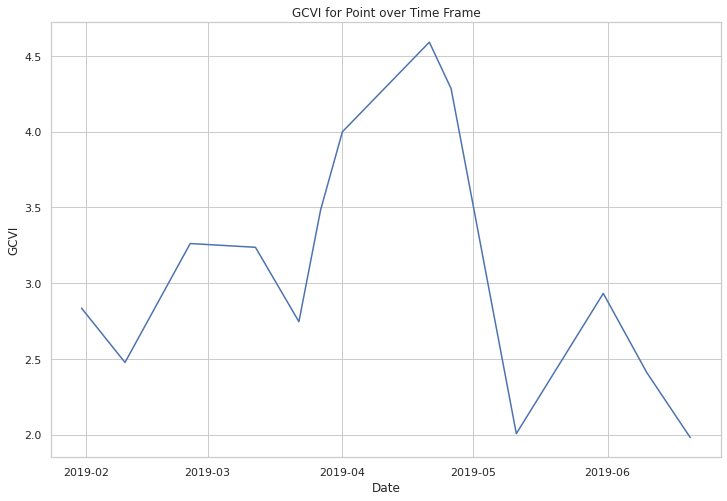

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
sns.set(style='whitegrid')

f,ax=plt.subplots(1,1, figsize=(12,8))

line = sns.lineplot(x='date',y='GCVI',data=gcvi_day_pixel_df,ax=ax)
ax.set_title('GCVI for Point over Time Frame')

ax.set_ylabel('GCVI')
ax.set_xlabel('Date')

We've plotted the mean GCVI values for our sample point f over our growing season. The values are fairly choppy, especially with the number of images masked due to cloud cover, which can make it more difficult to determine the pattern over time. This is why **smoothing** is often applied to indices in order to use them in determining crop phenology.   
  
Azzari et al. fit a **harmonic regression** model to the time series of each band, which means they include the time values within sine and cosine terms in their regression equation. For a brief introduction to using the sum of sine and cosine terms, known as a **Fourier series**, in functions representing periodic motion and to harmonic analysis, see this [Britannica](https://www.britannica.com/science/harmonic-analysis) explainer. While other methods have been explored for accurately capturing the changes in crops over seasons, the use of harmonic regression has been found to be successful in representing crop behavior.[<sup>11</sup>](#fn11) [<sup>12</sup>](#fn12)  
  
Azzari et al. also provide code which will perform this harmonic regression and return the coefficients, which are the values we will ultimately feed into our model. For Malawi, they use a harmonic regression model with two pairs of harmonic terms (ie, two sine and two cosine terms). Although for Ethiopia they find three pairs performs better, in their tests overall they did not find significant improvement from tuning the number of harmonic pairs, so for simplicity using two should suffice for most use cases. The code we'll be using allows us to specify how many harmonic pairs to use, with the default as 2, so this could be adjusted if needed. For our use case with two harmonic pairs, we'll be running the regression $$GCVI_t=\beta_0+\beta_1t+\beta_2cos(2\pi \omega_1t)+\beta_3sin(2\pi \omega_1t)+\beta_4cos(2\pi \omega_2t)+\beta_5sin(2\pi \omega_2t)+\epsilon$$ with $\omega_1=1$ and $\omega_2=2$.  
  
The function we'll be using, `run_std_regressions()` is stored in eetc/gee_tools/harmonics.py. To use it, we'll provide an ImageCollection of our band or index of interest (ie, selecting only the GCVI bands from our s2coll_2a index collection), the band we are interested in performing the regression on (ie, GCVI), a reference date if desired, and the number of harmonic pairs. There are also options to specify which time bands (constant, sine, cosine, etc) should be included, an option to specify the value of omega, and an option to return the result as an ImageCollection rather than a single Image with all bands, but these each have default values set which will work for our purposes.  
  
This function first adds our harmonic terms to the ImageCollection as new bands (ie, our specified number of sine, cosine, and time bands), performs the regression and computes the variance, $R^2$ (the proportion of our outcome of interest, GCVI, which our model successfully captures), and the root mean square error (rmse). The coefficients from the harmonic terms and these measures of the success of the model are all returned as separate bands in an Image. We'll demonstrate this process first with just GCVI to get a better understanding for the mechanism.  
  
    
      
<span id="fn11"> 11. Jin, Zhenong, George Azzari, Calum You, Stefania Di Tommaso, Stephen Aston, Marshall Burke, and David B. Lobell. 2019. “Smallholder Maize Area and Yield Mapping at National Scales with Google Earth Engine.” Remote Sensing of Environment 228 (July): 115–28. https://doi.org/10.1016/j.rse.2019.04.016.</span>  
  
<span id="fn12"> 12. Deines, Jillian M., Rinkal Patel, Sang-Zi Liang, Walter Dado, and David B. Lobell. 2021. “A Million Kernels of Truth: Insights into Scalable Satellite Maize Yield Mapping and Yield Gap Analysis from an Extensive Ground Dataset in the US Corn Belt.” Remote Sensing of Environment 253 (February): 112174. https://doi.org/10.1016/j.rse.2020.112174.</span>

In [18]:
# Import code we'll use from Azzari et al.
from eetc.gee_tools import harmonics

# Filter for only our index of interest in this example, GCVI
gcvi = s2coll_2a.select('GCVI')
# Specify band in the ImageCollection we want to use in regression
dep_bands = ['GCVI']

# Run the regression to produce an image with our terms as bands; using first day of growing season as refdate
hrmregr_coefs_gcvi = harmonics.run_std_regressions(gcvi,dep_bands,refdate='2018-10-20')

In [101]:
# Cycle through the bands to see our result
for band in hrmregr_coefs_gcvi.getInfo()['bands']:
    print(band['id'])

GCVI_sin2
GCVI_cos2
GCVI_sin1
GCVI_cos1
GCVI_t
GCVI_constant
GCVI_variance
GCVI_count
GCVI_mean
GCVI_rmse
GCVI_r2


This looks exactly correct - we have two sine terms, two cosine terms, a constant, a time term (t), and the variance, mean, rmse, and r2 for the model. The sine, cosine, constant, and time terms correspond to the $\beta$ coefficients in the regression above. In Appendix Table A2 of Azzari et al.'s working paper, we see these are the terms we're interested in obtaining for each of our bands or indices.   
  
##### OPTIONAL: Plot Smoothed Index Time Series

As an **optional step**, let's now try to recreate our time series plots above using the smoothed values for our indices. We can once again use GCVI and the extended time range for a more complete chart. We'll first need to obtain the coefficients using `harmonics.run_std_regressions()`, then we'll use these coefficients to fit our GCVI data to this regression curve, smoothing the output values. To fit the GCVI to our coefficients, we'll use `harmonics.fit_harmonics()`. We'll provide the coefficients, the `gcvi_ext` ImageCollection, an omega value (we'll use the default of 1), the number of harmonic pairs, the band of interest, and our same reference date of the start of the growing season. 

In [33]:
# Filter for only our index of interest in this example, GCVI
gcvi_ext = s2coll_2a_ext.select('GCVI')
# Specify band in the ImageCollection we want to use in regression
dep_bands = ['GCVI']

# Run the regression to produce an image with our terms as bands; using first day of growing season as refdate
hrmregr_coefs_gcvi_ext = harmonics.run_std_regressions(gcvi_ext,dep_bands,refdate='2018-10-20')

In [34]:
# create new, smoothed GCVI values by fitting the original to the harmonic regression with coefficients created above
hrmregr_fit_gcvi_ext = harmonics.fit_harmonics(hrmregr_coefs_gcvi_ext, gcvi_ext, omega=1,nharmonics=2,bands=dep_bands,refdate='2018-10-20')

Now, we could simply rerun our `extract_pixel_vals_dates()` function with these GCVI values fit to the harmonic regression, but this processing is much slower than that for the original values, so it will be helpful to reduce the processing needed as much as possible. We can do this by using the same list of timestamps and band_ids created in our first process as the list of Images with our location, ee_point_g, unmasked. We'll use the below function to create these lists from the DataFrame we generated above, `gcvi_time_pixel_vals`. We'll just have to specify that our band name will now be 'GCVI_HARMFIT' rather than 'GCVI'.

In [41]:
# generate lists of known images where our location is not masked
def create_lists_for_extract(df, suffix_to_remove, suffix_to_add):
    """
    Create list of band ids and timestamps from previously-generated
        DataFrame from extract_pixel_vals_dates(). 
    Inputs:
        df (DataFrame): DataFrame returned from extract_pixel_vals_dates()
        suffix_to_remove (str): original suffix added to Image system:index, 
            in the format of '_' + bandname
        suffix_to_add (str): new suffix to add to Image system:index in format
            '_' + new bandname
    Returns (list, list): list of timestamps, list of band ids as tuple
    """
    time_list = df['datetime'].to_list()
    band_list = df['band_id'].to_list()
    band_list = [band.replace(suffix_to_remove, '') for band in band_list]
    band_list = [band + suffix_to_add for band in band_list]

    return time_list, band_list

In [61]:
time_list, band_list = create_lists_for_extract(gcvi_time_pixel_vals, '_GCVI','_GCVI_HARMFIT')
band_list[0:5]

['20190131T073139_20190131T074730_T36LYH_GCVI_HARMFIT',
 '20190210T073039_20190210T074611_T36LYH_GCVI_HARMFIT',
 '20190225T072901_20190225T075255_T36LYH_GCVI_HARMFIT',
 '20190312T073019_20190312T074735_T36LYH_GCVI_HARMFIT',
 '20190322T072619_20190322T074833_T36LYH_GCVI_HARMFIT']

In [62]:
# use our function to extract values for each pixel
# NOTE: this will be VERY slow, much slower than the for the original values even using pre-filtered lists - choose a smaller time frame to minimize processing
# using Google Earth Engine to perform these calculations and extract as a .csv is also an option for faster processing
gcvi_hrmregr_time_pixel_vals = extract_pixel_vals_dates(hrmregr_fit_gcvi_ext, 'GCVI_HARMFIT', ee_point_g,band_list=band_list, time_list=time_list)

selecting band of interest GCVI_HARMFIT from imagecollection
filtering for only images containing point

    number of ids in list:   13
    
    first 5 ids in list:     ['20190131T073139_20190131T074730_T36LYH_GCVI_HARMFIT', '20190210T073039_20190210T074611_T36LYH_GCVI_HARMFIT', '20190225T072901_20190225T075255_T36LYH_GCVI_HARMFIT', '20190312T073019_20190312T074735_T36LYH_GCVI_HARMFIT', '20190322T072619_20190322T074833_T36LYH_GCVI_HARMFIT']
    

    number of dates in list:   13

    first 5 dates in list:     [Timestamp('2019-01-31 07:54:27'), Timestamp('2019-02-10 07:54:27'), Timestamp('2019-02-25 07:54:22'), Timestamp('2019-03-12 07:54:24'), Timestamp('2019-03-22 07:54:27')]
    
creating single image from imagecollection
created empty dataframe Empty DataFrame
Columns: [datetime, GCVI_HARMFIT, band_id]
Index: []
getting pixel values for img from 2019-01-31 07:54:27 ...
getting pixel values for img from 2019-02-10 07:54:27 ...
getting pixel values for img from 2019-02-25 07:54:22

In [67]:
# save as csv to avoid repeating the processing
gcvi_hrmregr_time_pixel_vals.to_csv('gcvi_hrmregr_ext_time_pixel_vals_pointg.csv',index=False)

In [68]:
# convert to datetime type
gcvi_hrmregr_time_pixel_vals['datetime'] = pd.to_datetime(gcvi_hrmregr_time_pixel_vals['datetime'])

# extract date from datetime
gcvi_hrmregr_time_pixel_vals['date'] = gcvi_hrmregr_time_pixel_vals['datetime'].dt.date
# group data by date, take mean of all GCVI_HARMFIT values for each date
gcvi__hrmregr_day_pixel_df = gcvi_hrmregr_time_pixel_vals.groupby('date')['GCVI_HARMFIT'].mean().reset_index()
gcvi__hrmregr_day_pixel_df.head()

,date,GCVI_HARMFIT
0,2019-01-31,2.825936
1,2019-02-10,2.658152
2,2019-02-25,2.782984
3,2019-03-12,3.200063
4,2019-03-22,3.515674


Now, to plot these values with smooth connecting lines to highlight the smoothing effect of the regression, we'll be using a package in Python called `scipy`, which has a set of functions to perform [Interpolation](https://docs.scipy.org/doc/scipy/tutorial/interpolate.html?highlight=interp1d), or estimating a function which defines data points along a line defined by known points of interest. For our case, we'll just be using `scipy.interpolate.interp1d` to create a smooth estimate of the line connecting our smoothed GCVI values. However, this function cannot use time as one of the dimensions for plotting, so we'll first need to convert our date to an ordinal date, which is a numeric type we'll be able to use with `interp1d` and plotting. The process below is derived from two helpful stackoverflow posts: one on using [ordinal dates for plotting](https://stackoverflow.com/questions/29308729/can-i-plot-a-linear-regression-with-datetimes-on-the-x-axis-with-seaborn) and one on using [interp1d for smooth plots](https://stackoverflow.com/questions/47361589/in-python-how-to-connect-points-with-smooth-line-in-plotting).

In [69]:
gcvi__hrmregr_day_pixel_df['date_ordinal'] = pd.to_datetime(gcvi__hrmregr_day_pixel_df['date']).apply(lambda date: date.toordinal())
gcvi_day_pixel_df['date_ordinal'] = pd.to_datetime(gcvi_day_pixel_df['date']).apply(lambda date: date.toordinal())

gcvi__hrmregr_day_pixel_df.head()

,date,GCVI_HARMFIT,date_ordinal
0,2019-01-31,2.825936,737090
1,2019-02-10,2.658152,737100
2,2019-02-25,2.782984,737115
3,2019-03-12,3.200063,737130
4,2019-03-22,3.515674,737140


/tmp/ipykernel_16707/3867862512.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(date_labels, rotation=45,fontsize=10)
/tmp/ipykernel_16707/3867862512.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),fontsize=10)


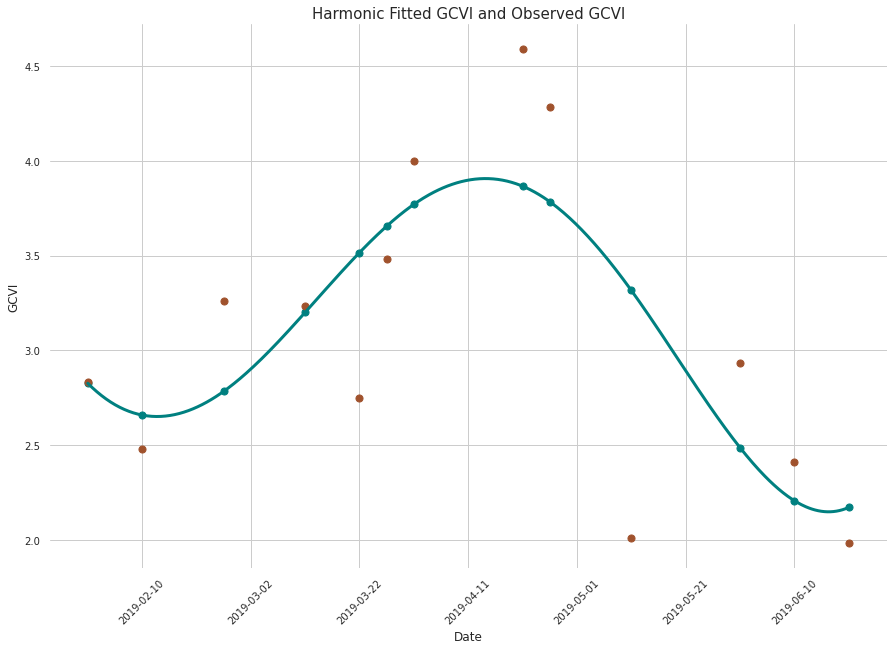

In [96]:
from scipy.interpolate import interp1d
import numpy as np

f, ax = plt.subplots(1,1,figsize=(15,10))

# obtain the original dates and gcvi values for plot f to use as comparison to our smoothed values
x_orig = gcvi_day_pixel_df['date_ordinal']
y_orig = gcvi_day_pixel_df['GCVI']

# obtain plot f dates and smoothed GCVI values to use as our x and y values
x = gcvi__hrmregr_day_pixel_df['date_ordinal']
y = gcvi__hrmregr_day_pixel_df['GCVI_HARMFIT']

# create 500 evenly spaced numbers over the range of our ordinal dates
xnew = np.linspace(x.min(),x.max(),500)

# approximate our function from the date and ndvi values
f = interp1d(x,y,kind='cubic')
# create y values, using our approximated function, to pair with our 500 x values 
y_smooth=f(xnew)

#plot the smoothed gcvi points from our dataset
plt.scatter(x, y,c='teal',s=50)
# plot the smoothed line connecting the points
plt.plot(xnew, y_smooth,c='teal', linewidth=3)
# plot the original gcvi points from our dataset
plt.scatter(x_orig, y_orig,c='sienna',s=50)


# define the axes and title labels
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('GCVI', fontsize=12)
ax.set_title('Harmonic Fitted GCVI and Observed GCVI',fontsize=15)

# create dates from ordinal dates to use along x axis for easy interpretation
date_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(date_labels, rotation=45,fontsize=10)
ax.set_yticklabels(ax.get_yticks(),fontsize=10)

# remove bounding box from plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()

We now have a visual representation of the GCVI changes in our sample point over time, with the teal dots and line demonstrating the smoothed values we obtained from `harmonics.fit_harmonics()`. The sienna dots are the original, observed GCVI values prior to smoothing. Though this is only a sample point, and should not be taken as representing maize or any other crop, performing the same process on an identified point provides an interpretable representation of the pattern in GCVI over time. This is useful not only in better understanding maize growth, but for our model it will be important as another factor to identify maize. Maize and most other crops have distinctive phenologies, which can be captured and represented by the vegetation indices created from satellite imagery. Thus, by providing our model with the coefficients from our regressions which define maize's unique phenology, the model will be better able to distinguish maize from other crops.  
    
##### Obtain Harmonic Coefficients
   
The final step is thus to obtain the mean values of coefficients for each of our plot areas of interest, so that we have a single number for each value for each plot. This will require the geographic boundaries of the plots to define the areas over which we'll calculate the mean. We'll use our sample plots created above, specifically, the versions of our plots we created in the `geemap` format: ee_plot_a, ee_plot_b, and ee_plot_c.    
    
Google Earth Engine provides a method, `reduceRegion()`, to compute statistics for images over a given area. For all of our GCVI features, we want to find the mean value for each plot - for example, the mean GCVI_cos1 for each plot over our selected time frame. We'll use a **reducer** for this purpose, which allow you to aggregate over areas, time, and bands, among other Image characteristics. We'll use the `ee.Reducer.mean()` to calculate the mean values of our Image. `reduceRegion()` enables us to define the reducer we want to use as well as the area to reduce over. For more information on reducing and this use case, see Google Earth Engine's [Computation Using Images](https://developers.google.com/earth-engine/tutorials/tutorial_api_03) tutorial.  
  
For an example, let's calculate the mean value of the GCVI bands for plot c.

In [21]:
# Calculate mean elevation for area
gcvi_c = hrmregr_coefs_gcvi.reduceRegion(
    reducer = ee.Reducer.mean(),
    geometry = ee_plot_c,
    scale = 30
)
mean_gcvi_constant = gcvi_c.get('GCVI_constant')
print('Mean constant from GCVI harmonic regression for plot c:',mean_gcvi_constant.getInfo())

Mean constant from GCVI harmonic regression for plot c: 263.0954490816946


We've just pulled out the GCVI_constant term, which is the constant from the harmonic regression on the GCVI band, but this method provides the mean for plot c for all bands in the hrmregr_coefs_gcvi Image.  
  
Though calculating these individual plot values can be helpful to validate that your process is working as expected, in practice it will be much more efficient to obtain these values for all plots of interest at once. We can use `ee.Image.reduceRegions()` to perform the same calculations of the mean for multiple areas. We'll need to feed `reduceRegions()` a `FeatureCollection` of all of our areas of interest, which we can easily create by converting our 'plots_gdf' GeoDataFrame to a FeatureCollection using `geemap.geopandas_to_ee()`.

In [13]:
ee_plots_gdf = geemap.geopandas_to_ee(plots_gdf)
ee_plots_gdf.getInfo()

{'type': 'FeatureCollection',
 'columns': {'index': 'Integer',
  'plot': 'String',
  'plot_area': 'Float',
  'system:index': 'String'},
 'features': [{'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': [[[34.557479999973054, -14.305433999844611],
      [34.55742399997311, -14.304968999845014],
      [34.556232999973126, -14.305095999845069],
      [34.55665099997305, -14.305579999844612],
      [34.557479999973054, -14.305433999844611]]]},
   'id': '0',
   'properties': {'index': 0,
    'plot': 'plot_a',
    'plot_area': 1.508916795533467}},
  {'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': [[[33.93234000038297, -11.56669100270623],
      [33.931981000383054, -11.566139002706953],
      [33.93116000038293, -11.566817002706246],
      [33.9314710003829, -11.56712700270583],
      [33.93234000038297, -11.56669100270623]]]},
   'id': '1',
   'properties': {'index': 0,
    'plot': 'plot_b',
    'plot_area': 1.6412662047939302}},
  {'type': 'F

By viewing the contents of our new FeatureCollection, we can see it's taken each row of our original GeoDataFrame and converted it to a `Feature`, which is comprised of a `geometry` (our plot polygons), a unique 'id', and 'properties' which include the plot name and plot area columns from the GeoDataFrame. This looks good! Now, we can obtain the mean for each index and band for each plot in this FeatureCollection.  
  
First, to demonstrate using the entire FeatureCollection with `reduceRegions()`, let's do an example of calculating the mean GCVI values for each of our plots. We'll use `reduceRegions()` with a similar set-up to our `reduceRegion()` code above, except instead of a 'geometry' value we'll provide a 'collection', which is our FeatureCollection containing each plot for which we want to calculate the mean aspect. Once `reduceRegions()` is performed, we'll have a FeatureCollection with additional properties for the mean values. We can convert this FeatureCollection back to a GeoDataFrame to more easily view our newly calculated data.

In [23]:
# Calculate mean GCVI values for areas
ee_plots_gcvi = hrmregr_coefs_gcvi.reduceRegions(
    reducer = ee.Reducer.mean(),
    collection = ee_plots_gdf,
    scale = 30
)
# convert to DataFrame
plots_with_gcvi = geemap.ee_to_pandas(ee_plots_gcvi)
plots_with_gcvi

,GCVI_constant,GCVI_cos1,GCVI_cos2,GCVI_count,GCVI_mean,GCVI_r2,GCVI_rmse,GCVI_sin1,GCVI_sin2,GCVI_t,GCVI_variance,index,plot,plot_area
0,678.805935,-303.735510,-54.051678,8.246671,2.978578,0.955892,0.111548,-267.402573,5.988830,-1853.809982,0.597549,0,plot_a,1.508917
1,12383.461693,206.360703,-282.059117,11.478678,2.562344,0.913124,0.112264,-6342.417208,-1134.519602,-23693.844957,0.198886,0,plot_b,1.641266
2,263.095449,-146.920897,-20.687845,34.418301,2.730780,0.420253,0.608733,-86.848001,11.031942,-777.544449,0.763646,0,plot_c,13.306660


Our final step is now to put all these pieces together to obtain the mean values for all of our bands and indices of interest for each of our plots. We can do this using a for loop to cycle through each band of interest, run the harmonic regression, obtain the coefficient values, calculate the mean for each plot, and return the results as a single DataFrame. Note that this may take some time, especially for many plots, as it needs to perform these calculations across each of them for multiple bands. 

In [24]:
# define bands of interest
bands_indices = ['RDED4','GCVI','NBR1','NDTI','NDVI','SNDVI']

# create empty dataframe to fill with values
s2_2a_df = pd.DataFrame()

# for each band, run harmonic regression to obtain seasonality features
for band in bands_indices:
    dep_bands = [band]

    # select only band/index of interest
    imgcoll = s2coll_2a.select(dep_bands)
    # run harmonic regression on ImageCollection
    hrmregr_img = harmonics.run_std_regressions(imgcoll,dep_bands,None)

    # Use resulting image to obtain mean for each region of interest
    means = hrmregr_img.reduceRegions(
        reducer = ee.Reducer.mean(),
        collection = ee_plots_gdf,
        scale = 30
    )
    # convert to DataFrame
    means_df = geemap.ee_to_pandas(means)
    # select only new fields and plot names to join
    means_df = means_df.drop(columns=['index','plot_area'])
    # if first band, define s2_2a_df as means_df
    if s2_2a_df.size == 0:
        s2_2a_df = means_df.copy()
    # else, join new bands onto s2_2a_df dataframe
    else:
        s2_2a_df = s2_2a_df.merge(means_df, on='plot')

s2_2a_df

,RDED4_constant,RDED4_cos1,RDED4_cos2,RDED4_count,RDED4_mean,RDED4_r2,RDED4_rmse,RDED4_sin1,RDED4_sin2,RDED4_t,...,SNDVI_cos1,SNDVI_cos2,SNDVI_count,SNDVI_mean,SNDVI_r2,SNDVI_rmse,SNDVI_sin1,SNDVI_sin2,SNDVI_t,SNDVI_variance
0,-518.412639,90.364250,-8.191404,8.246671,0.358509,0.865493,0.017484,-31.530930,-10.591325,433.689077,...,39.243345,-2.875033,8.246671,0.507617,0.957053,0.012290,-9.783135,-5.246965,179.517173,0.005259
1,-9569.437735,1547.635232,-221.995186,11.478678,0.324858,0.954085,0.004904,-956.855148,-120.576523,8243.978523,...,-4.821486,-97.810958,11.478678,0.380890,0.886615,0.007652,-454.925323,52.980992,670.055357,0.003972
2,-108.520916,17.013766,-2.311148,34.418301,0.286631,0.364254,0.052480,-10.650291,-1.127877,93.714036,...,3.434490,-0.123783,34.418301,0.428591,0.404706,0.057037,0.180259,-0.639135,12.999024,0.006167


This is a large dataframe, so we can view the columns we created to ensure we have all we expect:

In [25]:
s2_2a_df.columns

Index(['RDED4_constant', 'RDED4_cos1', 'RDED4_cos2', 'RDED4_count',
       'RDED4_mean', 'RDED4_r2', 'RDED4_rmse', 'RDED4_sin1', 'RDED4_sin2',
       'RDED4_t', 'RDED4_variance', 'plot', 'GCVI_constant', 'GCVI_cos1',
       'GCVI_cos2', 'GCVI_count', 'GCVI_mean', 'GCVI_r2', 'GCVI_rmse',
       'GCVI_sin1', 'GCVI_sin2', 'GCVI_t', 'GCVI_variance', 'NBR1_constant',
       'NBR1_cos1', 'NBR1_cos2', 'NBR1_count', 'NBR1_mean', 'NBR1_r2',
       'NBR1_rmse', 'NBR1_sin1', 'NBR1_sin2', 'NBR1_t', 'NBR1_variance',
       'NDTI_constant', 'NDTI_cos1', 'NDTI_cos2', 'NDTI_count', 'NDTI_mean',
       'NDTI_r2', 'NDTI_rmse', 'NDTI_sin1', 'NDTI_sin2', 'NDTI_t',
       'NDTI_variance', 'NDVI_constant', 'NDVI_cos1', 'NDVI_cos2',
       'NDVI_count', 'NDVI_mean', 'NDVI_r2', 'NDVI_rmse', 'NDVI_sin1',
       'NDVI_sin2', 'NDVI_t', 'NDVI_variance', 'SNDVI_constant', 'SNDVI_cos1',
       'SNDVI_cos2', 'SNDVI_count', 'SNDVI_mean', 'SNDVI_r2', 'SNDVI_rmse',
       'SNDVI_sin1', 'SNDVI_sin2', 'SNDVI_t', 'SNDVI_v

This set of columns aligns with the Sentinel-2 columns in Appendix Table A2 from Azzari et al., which means we've successfully obtained the necessary information from S2 for each of our plots to continue building our machine learning model. Note that, while we've calculated each of these fields, Azzari et al. pre-selected features to avoid **overfitting** for in their final model, and they've indicated these with * in Appendix Table A2. One of the concerns with machine learning models is that they can become too accustomed to the exact data provided and not learn how to accurately handle new data when you're trying to actually use the model. This will lead the model to seem to perform very well when you're predicting on your training dataset, but once you attempt to use it for other purposes, you'll see much poorer performance. Azzari et al. used Mutual Information score to determine which features to keep: $$MI(X;Y)=\int \int f(x,y)log\frac{f(x,y)}{f(x)f(y)}dxdy$$ and ensured no remaining features were highly correlated (ie, provided similar information). While performing this process yourself to select features would increase performance for your model, if desired the same features selected by Azzari et al. could be used for simplicity (see below). 

#### Shuttle Radar Topography Mission Data
  
To obtain the elevation, slope, and aspect information for our plots, we will use the Shuttle Radar Topography Mission Version 3.0, which we can find in Google Earth Engine as the Image `ee.Image("USGS/SRTMGL1_003")`.   
  
First, we'll set the variables to use in downloading the elevation data:  

In [21]:
# define GEE id of SRTM V3 Image
srtm = ee.Image('USGS/SRTMGL1_003')

We can obtain the elevation itself using the `srtm_id` and selecting the band `elevation`. Then, we can use this elevation Image along with the `ee.Terrain` package to obtain the slope and aspect information. 

In [22]:
elevation = srtm.select('elevation')
slope = ee.Terrain.slope(elevation)
aspect = ee.Terrain.aspect(elevation)

We want to calculate the elevation, slope, and aspect for each plot of land and store the values for use in our model. This will again require the geographic boundaries of the plots to define the areas over which we'll calculate average elevation, slope, and aspect. We can use the same `geemap` sample plots created above to calculate average elevation, slope, and aspect with the `reduceRegions()` method. To begin, though, let's first demonstrate with a single Image and plot: we'll calculate the mean slope in plot c using `reduceRegion()` and the `slope` Image we just created. 

In [23]:
# Calculate mean slope for area
slope_c = slope.reduceRegion(
    reducer = ee.Reducer.mean(),
    geometry = ee_plot_c,
    scale = 30
)
mean_slope_c = slope_c.get('slope')
print('Mean slope for plot c:',mean_slope_c.getInfo())

Mean slope for plot c: 2.4228431489192244


We can also visualize these topography characteristics on a map to get a better sense of what we're calculating. For example, if we'd like to view areas of higher slope, we can plot slope on top of a map of the areas we're interested in. 

In [24]:
center_lat = -13.600627
center_lon = 33.339620

elev_map = geemap.eefolium.Map(center=[center_lat,center_lon], zoom=9)
elev_map.addLayer(slope, {min:0, max: 90}, 'slope')
elev_map

In this example, we can visualize areas of higher and lower slope as shades of grey. While this provides the information we need, often it can be helpful to display satellige imagery using a more extensive color palette to more easily distinguish the gradient of values. Here's an example of the elevation we obtained from SRTM using a color palette from [this Bikesh Bade blog](https://bikeshbade.com.np/tutorials/Detail/?title=Generate%20Slope%20Elevation%20data%20from%20SRTM%20-%20Python%20API&code=7).

In [25]:
center_lat = -13.600627
center_lon = 33.339620


map_plot_c = geemap.eefolium.Map(center=[center_lat,center_lon],zoom=6)

terrain_params = {'min': 0, 'max': 1000, 'palette': [
    '3ae237', 'b5e22e', 'd6e21f', 'fff705', 'ffd611', 'ffb613', 'ff8b13',
    'ff6e08', 'ff500d', 'ff0000', 'de0101', 'c21301', '0602ff', '235cb1',
    '307ef3', '269db1', '30c8e2', '32d3ef', '3be285', '3ff38f', '86e26f'
  ]}
map_plot_c.addLayer(elevation, terrain_params, 'elevation')
map_plot_c

In order to obtain the elevation, slope, and aspect for all plots of interest for use in our model, we can use `ee.Image.reduceRegions()` to perform the same calculations for the mean for multiple areas. We'll use our `ee_plots_gdf` from the Sentinel-2 calculations for this purpose. While we can calculate slope, aspect, and elevation individually with `reduceRegions()`, as we just did above, it will be more efficient and ease reproducibility to use a for loop to calculate the means for each of our terrain measures and join them together as a single DataFrame. 

In [63]:
# define measures of interest
measure_images = {'elevation':elevation, 'slope':slope, 'aspect':aspect}
# create empty dataframe to store results
srtm_df = pd.DataFrame()

# for each measure, calculate the mean for all plots
for label, img in measure_images.items():
    means = img.reduceRegions(
        reducer = ee.Reducer.mean(),
        collection = ee_plots_gdf,
        scale = 30
    )
    # convert to DataFrame
    means_df = geemap.ee_to_pandas(means)
    # select only the mean and plot name to join
    # to the original; rename 'mean' for clarity
    means_df = means_df.loc[:,('plot','mean')].rename(columns={'mean':label})
    # if first terrain measure, define srtm_df as means_df
    if srtm_df.size == 0:
        srtm_df = means_df.copy()
    # else, join new terrain measures onto srtm_df DataFrame
    else:
        srtm_df = srtm_df.merge(means_df, on='plot')

srtm_df

,plot,elevation,slope,aspect
0,plot_a,522.309789,2.920060,98.295870
1,plot_b,1303.766563,11.103849,80.482079
2,plot_c,1050.255761,2.422843,131.906412


We can see that our final, updated DataFrame now has values for mean elevation, slope, and aspect for each of our plots. These values will be included in our model as useful information to help identify which areas are growing maize. 

#### aWhere Climate Data
  
In order to access the aWhere climate data, you'll first need an API Key and Secret which can be used to generate the access token used in each API request. For more information on OAuth2, which is the framework used to authorize and control access to aWhere's data store, see [OAuth 2 Simplified](https://aaronparecki.com/oauth-2-simplified/), by Aaron Parecki or other online resources.  

You can follow the steps in the [Getting Started](https://docs.awhere.com/knowledge-base-docs/getting-started/) guide to obtain your API Key as a Free user. Note that with 'Freemium' access, you cannot use this data for commercial purposes and you're limited in the API calls and years of data available. Once you've created your account and activated your API access for the Weather API, you will be provided your API Key and Secret. You should keep these in a secure location and not share them with any other users.  
  
Once you have your API Key and Secret, you can use them to generate an access token whenever you'd like to make an API call. Note that tokens expire after one hour.  
  
aWhere has provided sample code for use of its API with Python, which you can find in their [Git Repo](https://github.com/aWhereAPI/API-Code-Samples/tree/master/python). This sample code provides a straightforward interface for obtaining weather data which doesn't require significant customization, so we can use their script for our purposes. To make their code available for access on your machine, you can either clone their [API-Code-Samples repository](https://github.com/aWhereAPI/API-Code-Samples) according to the instructions in the Python folder, or if you are unfamiliar with Git, you can download a zip file of the code by selecting 'Download ZIP' in the dropdown of the green 'Code' button.  
  
<img src="img/aWhere-api-python-code-download.PNG" width="600" align="center"/>  
  
We'll need to create [fields](https://docs.awhere.com/knowledge-base-docs/field-plantings/) which tell aWhere the location of the weather data we're interested in. aWhere uses the center point of the plot and the number of acres to define a field, so if you're using the full plot boundary or corner points, you'll want to obtain the center point (the centroid) to use with aWhere. Fortunately, `GeoPandas` has an easy `.centroid` command which will return the center point for each of our geographic areas. For full precision, we'll want to reproject our polygons to a CRS suited to distance measurement, as we did above when calculating the area of the plots.

In [32]:
survey_gdf.to_crs('EPSG:20936').centroid.to_crs(4326)

0    POINT (34.55693 -14.30526)
1    POINT (33.93176 -11.56667)
2    POINT (33.33952 -13.60078)
dtype: geometry

Now, we'll create our fields. We'll use a process based off of the sample code, with some modifications to allow us to create fields based on our specified plot locations. First, to provide your credentials, navigate to the `API-Code-Samples/python` folder, open up the `awhere_demo.py` script, and enter your API Key and Secret where you see `# Enter your Api Key and Secret below:`.  
  
Next, you'll need to replace the existing `header.py` script with the `header.py` script in the Geo4Dev Git repository, located [here](https://github.com/Geo4Dev/Satellite-Crop-Type-Mapping/blob/main/header.py). This updated script includes two new _methods_ (a _method_ is a _function_ contained within a _class_ to be used on an _object_ of the _class_: for more information on Python classes, functions, and methods, see this [tutorial](https://data-flair.training/blogs/python-method/)). These additions will allow us to (a) create fields by specifing the field name, id, center point, and area in acres for each field we'd like to obtain weather data for and (b) get the Daily Observed Weather for fields and time periods of our choosing. The names of these methods are `create_field()` and `get_observed_weather()`, respectively.   
    
Finally, you'll import these scripts to use in our process here. We'll use `sys.path.insert()` to point Python to the scripts we want to use, then we'll import the necessary functions and values (namely, the api_key and api_secret).  
  
NOTE: Because these scripts were made to be used via a user interface, when you run the below code you'll see the full explanation of the Demo and be prompted to imput a number to choose an option. Enter '0' (Quit) to skip this and continue. 

In [49]:
import sys
# point Python to the path where the scripts are stored
sys.path.insert(1,'./API-Code-Samples/python/')

from header import AWhereAPI
from awhere_demo import api_key, api_secret

sh: 1: read: arg count


		**********************************************
		****  aWhere API Python Demo Application  ****
		**********************************************


This python demo is intended to display basic examples of how you
can interact with the aWhere API Platform. 

The application was written in Python 3 but it should be backwards 
compatible with Python 2. It uses the "requests" library to perform HTTP requests.

To continue, you'll need to have already created a Developer 
profile via our Developer Community.

	 Register here ---> https://developer.awhere.com/api/get-started

Next, you'll need to login to your profile and create an app.
Upon creation of your app you'll be provided two keys, a secret key and an API key.


Be sure to enter your keys in the awhere_demo.py file!


Please input one of the following options and then press "Enter"

	 1. [GET] Get all fields associated with your account
	 2. [GET] Get Weather (Forecast, Norms and Observations) for an existing field
	 3. [POST] Cre

We can now demonstrate the use of the API to create our field 'plot_a', specifying the plot id, name, center point, number of acres, and an id for our farm.

In [11]:
aWhere = AWhereAPI(api_key, api_secret)
aWhere.create_field(1, 'plot_a', -14.30526, 34.55693, acres=2, farm_id='FarmTest')

Attempting to create new field....

The server responded with a status code of 201 

{'_links': {'awhere:agronomics': {'href': '/v2/agronomics/fields/1/agronomicvalues'},
            'awhere:forecasts': {'href': '/v2/weather/fields/1/forecasts'},
            'awhere:observations': {'href': '/v2/weather/fields/1/observations'},
            'awhere:plantings': {'href': '/v2/agronomics/fields/1/plantings'},
            'curies': [{'href': 'http://awhere.com/rels/{rel}',
                        'name': 'awhere',
                        'templated': True}],
            'self': {'href': '/v2/fields/1'}},
 'acres': 2.0,
 'centerPoint': {'latitude': -14.30526, 'longitude': 34.55693},
 'farmId': 'FarmTest',
 'id': '1',
 'name': 'plot_a'}




Your field "plot_a" was successfully created!


We can see from the helpful output that our plot has successfully been registered as a field with aWhere! We can confirm by utilizing the pre-built process provided by the sample code: open up a command terminal, navigate to the `API-Code-Samples/python` folder using the 'cd' command followed by the folder path (for example, 'cd Documents/Crop-Type-Mapping/API-Code-Samples/python/', and type `python awhere_demo.py`.  
  
You'll be presented with the following options:  
  
<img src="img/python_api_code_options.PNG" width="500" align="center"/>  
  
Type '1' to see the list of fields associated with your account. Since I just added 'plot_a' in the script above, I receive the following list of one field:  
  
<img src="img/awhere_field_list_single.PNG" width="400" align="center"/>   
  
This confirms I now have a field associated with my account. However, while this process will allow us to add fields, it would be a great deal of manual work to add each plot individually. Instead, one option is to create a simple `for loop` in Python, which will iterate through each of the plots in our GeoDataFrame and create a field for each one. To demonstrate this, I'll delete the sample field I just created and instead add all my sample plots using a for loop. (To delete fields within this interface, type '4', then type the field ID you'd like to delete. In my example, this is id '1'. Type '0' to exit the interface.)  
  
  
To build our for loop, which will be more useful for large collections of plots, we'll first add the plot centroids to each plot in our sample_gdf GeoDataFrame. To obtain just the latitude or longitude of a center point from `.centroid` we can use `.centroid.x` for longitude and `.centroid.y` for latitude.  

In [36]:
survey_gdf['center_lon'] = survey_gdf.to_crs('EPSG:20936').centroid.to_crs(4326).x
survey_gdf['center_lat'] = survey_gdf.to_crs('EPSG:20936').centroid.to_crs(4326).y
survey_gdf

,unique_id,hh_id,garden_id,plot_id,crop_code_a,crop_code_b,crop_code_c,crop_code_d,crop_code_e,plot_area,geometry,plot,maize_pos,center_lon,center_lat
0,0002-001-RG04-R01,0002-001,RG04,R01,1,34,12.0,NaN,None,1.508917,"POLYGON ((34.55748 -14.30543, 34.55665 -14.305...",plot_a,1,34.556929,-14.305258
1,0049-005-RG02-R01,0049-005,RG02,R01,12,38,NaN,NaN,None,1.641266,"POLYGON ((33.93234 -11.56669, 33.93147 -11.567...",plot_b,0,33.931765,-11.566670
2,0087-003-RG03-R02,0087-003,RG03,R02,1,28,38.0,42.0,None,13.306660,"POLYGON ((33.34090 -13.60151, 33.33913 -13.602...",plot_c,1,33.339522,-13.600782


Now, we'll iterate through each row to create our fields.

In [ ]:
aWhere = AWhereAPI(api_key, api_secret)
for idx, plot in survey_gdf.iterrows():
    aWhere.create_field(plot['unique_id'], plot['unique_id'], plot['center_lat'], plot['center_lon'], acres=plot['plot_area'], farm_id='FarmTest')

Now we're really getting somewhere! We can confirm our fields were added using the same process as before of typing `python awhere_demo.py` and then entering '1' to get a list of the fields we added.   
  
##### Obtaining Observed Weather  
  
Our next step will be to pull observed weather data for each of the fields for the dates of the growing season for your crop and location of interest. For simplicity in this example, we'll be using a range of just a few days, but the same process will be applicable to a full growing season.  

In [50]:
# authenticate our connection to aWhere
aWhere = AWhereAPI(api_key, api_secret)

# For each plot in our GeoDataFrame, pull the weather for the specified date range
weather = {}
for idx, plot in survey_gdf.iterrows():
    plot_id = plot['unique_id']
    print('Obtaining weather for plot',plot_id)
    resp = aWhere.get_observed_weather(plot_id, '2020-03-01','2020-03-05')
    weather[plot_id] = resp['observations']

Obtaining weather for plot 0002-001-RG04-R01
Obtaining weather for plot 0049-005-RG02-R01
Obtaining weather for plot 0087-003-RG03-R02


We can check the contents of `weather` to confirm we were successful, using the plot ID to specify which plot we're interested in. For example, to see the full set of weather data we pulled for plot '0002-001-RG04-R01', we'd use:  

In [152]:
weather['0002-001-RG04-R01']

[{'date': '2020-03-01',
  'location': {'latitude': -14.305258347052417,
   'longitude': 34.55692925628822,
   'fieldId': '0002-001-RG04-R01'},
  'temperatures': {'max': 26.979999542236328,
   'min': 21.229999542236328,
   'units': 'C'},
  'precipitation': {'amount': 0.0, 'units': 'mm'},
  'solar': {'amount': 5064.146484375, 'units': 'Wh/m^2'},
  'relativeHumidity': {'max': 92.18000030517578, 'min': 69.05999755859375},
  'wind': {'morningMax': 5.948584079742432,
   'dayMax': 6.0290846824646,
   'average': 4.642545223236084,
   'units': 'm/sec'},
  '_links': {'self': {'href': '/v2/weather/fields/0002-001-RG04-R01/observations/2020-03-01'},
   'curies': [{'name': 'awhere',
     'href': 'http://awhere.com/rels/{rel}',
     'templated': True}],
   'awhere:field': {'href': '/v2/fields/0002-001-RG04-R01'}}},
 {'date': '2020-03-02',
  'location': {'latitude': -14.305258347052417,
   'longitude': 34.55692925628822,
   'fieldId': '0002-001-RG04-R01'},
  'temperatures': {'max': 28.110000610351562

The data we received is broken down by date and provides information such as the latitude and longitude, fieldID, min and max temperatures, precipitation, wind, and humidity. We're interested in obtaining the average temperature, number of growing degree days (days when the mean temperature is greater than the base value needed for crop growth), and total precipitation. We can calculate these values for each plot by pulling the necessary values from this weather data.  

In [51]:
import numpy as np

# create empty dataframe to store final values for each plot
weather_df = pd.DataFrame(columns=['unique_id','Mean Temp (C)','GDD','Precipitation (mm)'])

# loop through each row of the sample_gdf dataframe
for idx, plot in survey_gdf.iterrows():
    plot_id = plot['unique_id']
    # obtain full weather API data for plot
    plot_weather = weather[plot_id]

    # create empty / initial objects for measures of interest
    mean_temps = []
    GDD = 0
    precipitation = 0
    
    # for each date, calculate average temp and add to GDD or precipitation if appropriate
    for date in plot_weather:
        # calculate mean temperature as mean of min and max
        temps = date['temperatures']
        mean_temp = (temps['max'] + temps['min']) / 2
        mean_temps.append(mean_temp)
        
        # if mean temp is greater than base value for crop growth, add a GDD
        if mean_temp >= 10:
            GDD = GDD + 1

        # add any precipitation for the day to the total for the plot
        precipitation = precipitation + date['precipitation']['amount']

    # calculate overall mean temperature for all days
    mean_temp_season = np.mean(mean_temps)
    print('\nCollected values for',plot_id,':\nMean Temp',mean_temp_season,'\nPrecipitation',precipitation, '\nGrowing Degree Days',GDD,'\n')
    
    # add calculated values for plot to weather_df dataframe
    weather_df = weather_df.append({'unique_id':plot_id,'Mean Temp (C)':mean_temp_season,'GDD':GDD,'Precipitation (mm)':precipitation},ignore_index=True)

# view created dataframe with all weather measures for each plot
weather_df.head()


Collected values for 0002-001-RG04-R01 :
Mean Temp 23.75 
Precipitation 0.4675000011920929 
Growing Degree Days 5 


Collected values for 0049-005-RG02-R01 :
Mean Temp 20.63400001525879 
Precipitation 55.725499391555786 
Growing Degree Days 5 


Collected values for 0087-003-RG03-R02 :
Mean Temp 21.22599983215332 
Precipitation 23.675000190734863 
Growing Degree Days 5 



,unique_id,Mean Temp (C),GDD,Precipitation (mm)
0,0002-001-RG04-R01,23.750,5,0.467500
1,0049-005-RG02-R01,20.634,5,55.725499
2,0087-003-RG03-R02,21.226,5,23.675000


We now have the final temperature, growing degree days, and precipitation for each plot in this weather_df table. Along with the survey data, Sentinel-2 values, and SRTM terrain measures, we now have all the features we'll use to build out our model for crop type identification.  
  
    
## Generate Composites
  
In order to utilize all our information in a random forest model, we'll need to combine all the information corresponding to each plot in the same table. Python makes it easy to use Pandas DataFrames in machine learning models, so we will combine each individual DataFrame or GeoDataFrame we created above (the selected Survey information, the Sentinel-2 values, the Shuttle Radar Topography Mission data, and the weather data) into the same table and join by plot. Pandas provides a few options for joining tables, but for this purpose we can use `pd.merge()`, which performs a database-like join using according to specified fields. For more information on `merge`, see the Pandas [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html?highlight=merge#pandas.DataFrame.merge), and for information on the ways to combine tables in Pandas, see this [user guide](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html).  
  
We'll need to perform three `pd.merge()` commands to combine all 4 tables.

In [64]:
merged = survey_gdf.merge(weather_df, on = 'unique_id')
merged = merged.merge(s2_2a_df, on = 'plot')    
merged = merged.merge(srtm_df, on = 'plot')   
merged

,unique_id,hh_id,garden_id,plot_id,crop_code_a,crop_code_b,crop_code_c,crop_code_d,crop_code_e,plot_area,...,SNDVI2_mean,SNDVI2_r2,SNDVI2_rmse,SNDVI2_sin1,SNDVI2_sin2,SNDVI2_t,SNDVI2_variance,elevation,slope,aspect
0,0002-001-RG04-R01,0002-001,RG04,R01,1,34,12.0,NaN,None,1.508917,...,0.521993,0.993196,0.000635,79.867239,0.604118,-514.118512,0.005090,522.309789,2.920060,98.295870
1,0049-005-RG02-R01,0049-005,RG02,R01,12,38,NaN,NaN,None,1.641266,...,0.377832,0.852364,0.003445,-2143.819804,-364.332682,21883.055554,0.003793,1303.766563,11.103849,80.482079
2,0087-003-RG03-R02,0087-003,RG03,R02,1,28,38.0,42.0,None,13.306660,...,0.432080,0.479580,0.049154,40.881982,-0.579525,-249.746485,0.005420,1050.255761,2.422843,131.906412


### Excluding Plot Observations 
  
Azzari et al. find that excluding plot observations according to a minimum plot threshold harms model performance, so we do not apply any minimum threshold for plot size.  
  
### Sample Size  
  
Azzari et al. consider a variety of sample sizes in their tests to determine the minimum number of plots to use for this model to perform accurately. While the sample size will be dependent on the survey data you have available, they find that approximately 3,000 - 4,000 plots is necessary for best performance when you are using full plot boundaries, plot corner points, or plot centroids. If you do have more plot data available, it will likely make your model stronger if you use all of your available plots.

 ### Feature Pre-Selection  
  
As mentioned above, Azzari et al. also perform _feature pre-selection_ as the first step of their classification pipeline in order to prevent overfitting caused by the high number of features available in the data set. They utilize Mutual Information score as the criterion for selecting or removing features.
  
While they perform pre-selection on each data set they test for performance, as we will only be using the method they found to be highest-performing, we can pre-select our features according to this method's findings. To perform your own feature pre-selection, which may produce different results depending on the location and time period under consideration, you can utilize the same formula to determine the features to remove from your dataset. Following their selections, however, we will filter our merged dataset:  
  
`merged_preselected = merged_samp.loc[:,('maize_pos','district','GDD', 'Ptot', 'aspect', 'elevation', 'slope', 'GCVI_cos2', 'GCVI_r2', 'GCVI_rmse', 'GCVI_variance', 'NBR1_cos1', 'NBR1_cos2', 'NBR1_r2', 'NBR1_rmse', 'NBR1_sin2', 'NDTI_constant', 'NDTI_cos1', 'NDTI_cos2', 'NDTI_r2', 'NDTI_rmse', 'NDTI_sin2', 'NDTI_variance', 'NDVI_cos1', 'NDVI_cos2', 'NDVI_mean', 'NDVI_sin1', 'NDVI_sin2', 'RDED4_constant', 'RDED4_cos1', 'RDED4_r2', 'RDED4_rmse', 'RDED4_sin1', 'RDED4_sin2', 'RDED4_t', 'SNDVI_r2', 'SNDVI_rmse', 'SNDVI_variance')]`

## Train and Tune Model
  
### Train and Test Subsets  
  
Once we have the complete feature set for use in our model, we will prepare the data for use in model training by splitting into _train_ and _test_ subsets. Azzari et al. stratify the data by district and crop type - utilizing the crop of interest, maize, as one crop type category and all other crops as the second category - prior to splitting in order to ensure all subsets have the same balance of plots. We can utilize `scikit-learn's` function `sklearn.model_selection.train_test_split()` to split our data. `train_test_split()` takes an array or matrix, as in our case, as an input and splits the data into specified sizes and according to any given stratification to produce training and testing datasets for both the X and Y (independent and dependent) features. For more information on `train_test_split()`, see the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). We can split our data two times to obtain train and test subsets as 80 and 20 percent of the total, respectively. The code will be structured as follows:  
  
`y = merged_preselected['maize_pos']`  
`X = merged_preselected.loc[:,'GDD':'SNDVI_variance']` # select all columns between GDD and SNDVI_variance  
  
To create the split, we will split into train/test with the proportion assigned to test as 0.20.  
  
`X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.20, random_state = 100, stratify=merged_preselected.loc[:,('maize_pos','district')])`  
  
This will leave us with 4 different data chunks: train and test for our X features (X_train, X_test) and train and test for our feature of interest, maize_pos (y_train  y_test).   
  
While the process we use below to train our model will not actually utilize the _test_ dataset, this can be used if you want to refine your model to your particular dataset. For example, you can use the test set to perform your own feature pre-selection rather than using Azzari et al.'s selected features. The test set can also be used to plot **validation curves** or **learning curves** to evaluate whether your model is over or underfitting. For a brief introduction to these curves, see [scikit-learn's Validation curves guide](https://scikit-learn.org/stable/modules/learning_curve.html).
  
### Hyperparameter Tuning
  
We now can utilize the training dataset to tune our hyperparameters with a grid search and cross-validation. **Hyperparameters** are parameters of a machine learning model which do not come from the data but instead are set prior to training the final model. For example, a random forest model can use multiple different criteria for determining how 'close' each field is to the others according to the training data provided, and the criterion used is a hyperparameter which is set prior to model training.   
  
A **grid search** is a process which is performed prior to the final model training in order to determine which hyperparameters provide the best model performance. In a grid search, multiple combinations of hyperparameters are tested to determine the best combination for performance.   
  
We'll also use cross-validation to make this testing more comprehensive. **Cross-validation** essentially trains and tests multiple models on different subsets, or **folds**, of the training data to arrive at a more robust estimate of model performance. For example, if our training dataset was an (unrealistically small) 100 records and we set our number of 'folds' to be k = 5, we would have 5 folds of 20 records. In the first cross-validation step, the first fold of 20 will be left out while the other four folds are used to train a model. Then, the model which is trained will be used on the first fold and the performance assessed. Next, the second fold will be left out and the other four folds (the first, third, fourth, and fifth) will be used to train the model again, with the performance assessed on the held-out second fold. This process wil continue until all five folds have been used to evaluate a model, and the combined performance of all five models will be used as our performance estimate. 
  
Scikit-learn has a function to perform this grid search with cross-validation, `GridSearchCV()`. We'll use the `sklearn.ensemble.RandomForestClassifier()` with `sklearn.pipeline.Pipeline()` and `sklearn.model_selection.GridSearchCV()` to tune our hyperparameters.    
  
`from sklearn.ensemble import RandomForestClassifier`  
`from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score`  
`from sklearn.pipeline import Pipeline`  
`from sklearn.model_selection import GridSearchCV`    
`rf_pipeline = Pipeline([
    ('rf', RandomForestClassifier())
    ])`  
`rf_params = {
          'rf__n_estimators': (100,1000,5000),
          'rf__criterion': ('gini','entropy'),
          'rf__max_depth': (1,3,5),
          'rf__min_samples_split': (2,5,10),
          'rf__random_state': [10]
         }`  
`k = 10`  

`rf_grid_model = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_params,
    cv=k,
    scoring=['accuracy','precision','recall'],
    refit='accuracy' 
)`
  
`crop_fitted = rf_grid_model.fit(X_train, y_train.ravel())`  
`crop_results = crop_fitted.cv_results_`  
`crop_results = pd.DataFrame(crop_results)`  

# GENERATE PREDICTED CULTIVATION MAPS
  
## Apply Trained Model to Full Area of Interest

Once you've identified the hyperparameters which produce the best-performing model using `GridSearchCV()`, you can use these hyperparameters in a final, optimized Random Forest model to train your **entire** set of training data. For an example, if the top performing model identified in your Grid Search used a number of `estimators` of 1000, used entropy as the `criterion`, had a `max depth` of 3, and used a `min samples split` of 5, your final model would look something like this:  
  
`rf_best = RandomForestClassifier(criterion = 'entropy', max_depth = 3, min_samples_split = 5, n_estimators = 1000, random_state=10)`  
`rf_best_fit = rf_best.fit(X_train, y_train.ravel())`  
   
Now that you have a trained Random Forest model (`rf_best_fit`), you'll want to apply it to your entire area of interest at the pixel level. Python doesn't perform as well with this quantity of satellite imagery (as witnessed by obtaining a single pixel's GCVI in the optional section above on plotting time series). Instead, it's recommended to use Google Earth Engine's [Code Editor](https://code.earthengine.google.com/) to export an Image to [Google Drive](https://developers.google.com/earth-engine/apidocs/export-image-todrive) or [Google Cloud storage](https://developers.google.com/earth-engine/guides/exporting#to-cloud-storage) containing bands for our features of interest (that is: Sentinel-2 coefficients, terrain, weather). This can be accomplished using some of the tools provided in [this](https://github.com/shrutijain90/eetc) repo.
    
Once this data is exported to your drive, you can import it (for this example, say we've imported the data as `full_pixel_features`) for use with your trained model. Note that the exports from GEE will be in the form of .tif files. You can use the package `gdal` or `rasterio` to transform them into numpy arrays, which can then be fed to our trained model. You will need to use `gdal` or `rasterio` again after using scikit-learn to make predictions to transform the predicted arrays back into rasters. For an example of converting rasters into numpy arrays using `rasterio`, see below.
  
To usse our trained model to classify the pixel-level data we exported from GEE, I'm using [predict_proba()](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.predict_proba), which provides the predicted probability of being maize for each pixel. There is also the option of using [predict()](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to get a yes or no classification of maize, but obtaining the predicted probabilities for each pixel will allow more flexibility in classifiying according to your needs.    
  
`pred_pixels = rf_best_fit.predict_proba(full_pixel_features)`  
    
While we are unable to share full data here, from these results you'll have obtained **probability rasters** - ie, probabilities of maize at the pixel level - for the crop's cultivation.  
  
## Generate Predicted Cultivation Maps
  
We'll use a sample of the probability rasters created by Atlas AI to demonstrate the final step of using your probability rasters to generate masks, or maps, of pixels with your crop's cultivation. We'll continue using the example of Malawi, and we'll demonstrate this process using a cropland probability raster and maizeland probability raster both centered around our sample plot c. The **cropland raster** contains the predicted values for whether land is cultivated by any crops, while the **maizeland raster** contains the predictions for whether land is cultivated by maize. Atlas AI use both to create their final maps of maize locations: first, they filter their prospective areas to only those likely to be cultivated by any crop, according to the cropland raster, then they further demarcate these areas by their likelihood to contain maize, according to the maizeland raster. 
  
To work with this raster data, I'll be using two additional Python packages: `rasterio` and `earthpy`. Rasterio is a package for accessing raster files and can be installed either with pip according to the [documentation](https://rasterio.readthedocs.io/en/latest/installation.html) or with conda-forge according to the [instructions](https://github.com/conda-forge/rasterio-feedstock). Eartphy is a Python package for using spatial and remote sensing data, and it requires `rasterio` as well as `geopandas` and `numpy` to function. You can install it either with conda, according to the [conda instructions](https://github.com/earthlab/earth-analytics-python-env), or with pip according to the [documentation](https://earthpy.readthedocs.io/en/latest/get-started.html#install-earthpy). For more information on working with raster data in Python, including some of the techniques used here, see the [Earth Lab's Intermediate Earth Data Science Textbook](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/fundamentals-raster-data/open-lidar-raster-python/), Section 3, Chapter 4. 
  
The cropland probability raster we'll be using provides a probability, scaled from 0 to 100, of crop cultivation being present for a given pixel. The maizeland probability raster is in the same format, but it provides the probability of maize being present. Let's first open these `.tif` files using `rasterio.open()` to begin working with them.

In [3]:
import rasterio
from rasterio.plot import show, plotting_extent
import earthpy as et
import earthpy.plot as ep 

cropland_file = './atlasai_crop_maize_raster_2019_sample/cropland_2019.tif'
maizeland_file = './atlasai_crop_maize_raster_2019_sample/maizeland_2019.tif'

cropland_raster = rasterio.open(cropland_file)
maizeland_raster = rasterio.open(maizeland_file)

We now have access to the contents of these files, but we don't have the actual data yet. To obtain the values of each pixel represented as a numpy array, we can use `.read()`:

In [23]:
maizeland_raster.read()

array([[[69, 72, 53, ..., 85, 85, 79],
        [63, 57, 52, ..., 85, 83, 83],
        [70, 57, 49, ..., 73, 85, 86],
        ...,
        [71, 73, 68, ..., 72, 76, 80],
        [74, 74, 64, ..., 68, 78, 85],
        [75, 72, 65, ..., 76, 76, 80]]], dtype=uint8)

In [24]:
# summary of the size of maizeland_raster contents
maizeland_raster.read().shape

(1, 2004, 2049)

`.read()` takes in the entire file and provides the contents in a 3-dimensional array with the 3 axes being `(bands, rows, columns)`. We can see from the results of `.shape()` that the sample maizeland raster produced by our model only has one band: the first number in `.shape()`. This band is the probabilities of maize being present at that pixel. Since we only have one band, we can simplify the final array that we create from the raster by only reading the 1st band to produce a 2-dimensional array:

In [25]:
maizeland_array = maizeland_raster.read(1)
maizeland_array

array([[69, 72, 53, ..., 85, 85, 79],
       [63, 57, 52, ..., 85, 83, 83],
       [70, 57, 49, ..., 73, 85, 86],
       ...,
       [71, 73, 68, ..., 72, 76, 80],
       [74, 74, 64, ..., 68, 78, 85],
       [75, 72, 65, ..., 76, 76, 80]], dtype=uint8)

The `rasterio` documentation has more information on [reading](https://rasterio.readthedocs.io/en/latest/topics/reading.html) and [writing](https://rasterio.readthedocs.io/en/latest/topics/writing.html) `.tif` files and raster data. For now, though, let's visualize these probabilities as maps to see what the product of our work actually contains:

Text(0.5, 1.0, 'Maizeland Raster')

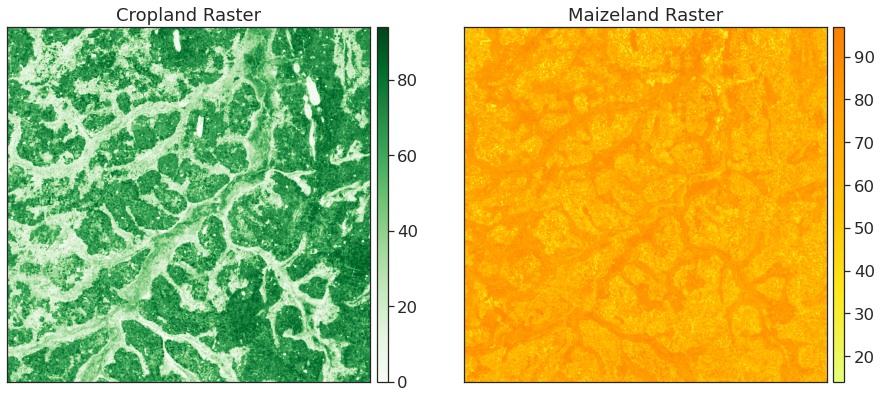

In [177]:
f, (ax1,ax2) = plt.subplots(1,2,figsize=(15,8))
ep.plot_bands(cropland_raster.read(1),cmap='Greens',ax=ax1)
ax1.set_title('Cropland Raster')
ep.plot_bands(maizeland_raster.read(1),cmap='Wistia',ax=ax2)
ax2.set_title('Maizeland Raster')

We can see that each raster provides a range of values from 0 to close to 100, each representing a different pixel in our 20m x 20m area. These are the values which Azzari et al. utilize to create their final predictions for maize.  
  
First, they utilize the cropland raster and define any pixel with a probability 40 or greater to be cropland. They remove all pixels with probability less than 40 from this cropland raster to arrive at a representation of all likely cropland pixels.  
  
This map of likely crop areas is then used to filter the maizeland raster to only those areas which are cropland. The remaining maizeland pixels are then assigned either as maize or not maize depending on their probability score, with a threshold of 60 percent as the cutoff for the presence of maize.   

I'll demonstrate this process below using `earthpy.mask.mask_pixels()` to remove pixels we identify as not crops or not maize.   

<AxesSubplot:>

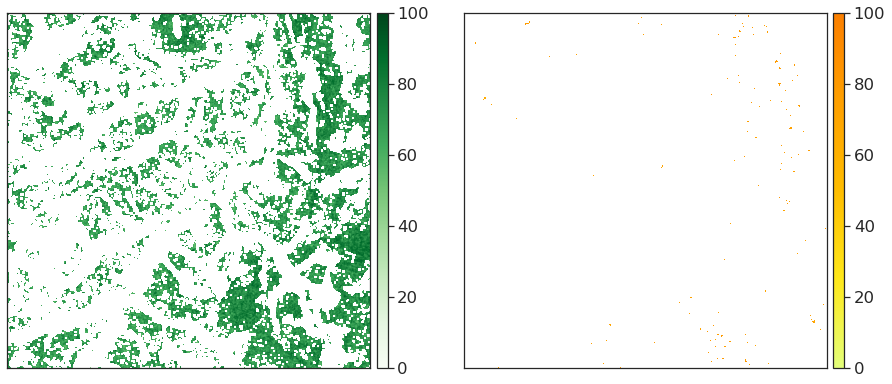

In [195]:
import earthpy.mask as em  

f, (ax1,ax2) = plt.subplots(1,2,figsize=(15,8))

# create separate array of true/false values for pixels above/below 40 percent threshold
cropland_mask = cropland_raster.read(1) < 40
# use true/false array to remove all pixels which were below 40 percent
cropland_masked = em.mask_pixels(cropland_raster.read(1), cropland_mask)

# remove all pixels from maizeland raster which do not contain crops
maizeland_crop_masked = em.mask_pixels(maizeland_raster.read(1), cropland_mask)

# create array of remaining maizeland pixels as either above/below the 60 percent threshold
maizeland_mask = maizeland_crop_masked < 60
# remove all maizeland pixels which were below 60 percent
maizeland_masked = em.mask_pixels(maizeland_crop_masked, maizeland_mask)

# plot final rasters identifying cropland and maizeland predicted from models
ep.plot_bands(cropland_masked,cmap='Greens',ax=ax1,scale=True,vmin=0,vmax=100)
ep.plot_bands(maizeland_masked,cmap='Wistia',ax=ax2,scale=True,vmin=0,vmax=100)

Our final product will thus be `maizeland_masked`, which was created by first removing all pixels not identified as cropland (note that we're able to use cropland_mask on our maizeland_raster only because both rasters cover an the same area; if not, the pixels would not align and our masking would be incorrect). Then, we created an additional mask of all maizeland pixels below a 60 percent probability of being maize, and we filtered these pixels out from our final `maizeland_masked` product. The final product showing predicted areas of crops can subsequently be used for any research or policy analyses which require accurate information on the location of crop growth.
    
This process tested and refined by Atlas AI contributes to enabling policymakers in resource-constrained settings to incorporate agricultural evidence as they implement improvements. With agricultural growth a primary development goal, this information can be invaluable. While generating predictions for crop locations from a machine learning model will necessarily involve some inaccuracies when compared to ground-truth survey data, the Atlas AI team has demonstrated strong performance from a model developed according to their specifications. In areas where very limited ground-truth information exists, the high-performance predictions this process can generate are a unique source to enable evidence-driven decision making.